In [ ]:
!pip install pymysql
import pymysql
import pandas as pd
import numpy as np
from google.colab import data_table

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 925.0 kB/s eta 0:00:00


In [ ]:
data_table.enable_dataframe_formatter()
cnx = pymysql.connect(user='buspark', password='U@5p1r3!',
                              host='masscourtsplus.org',
                              database='wp_courtdocs')


cursor = cnx.cursor()

In [ ]:
from google.colab import files

# **Table Previews and Data Cleaning**

## **cdocs_case_action_index**

In [ ]:
query = """
SELECT *
FROM cdocs_case_action_index
LIMIT 100;
"""
df = pd.read_sql(query, cnx)

# Display the DataFrame

# Save the DataFrame to a CSV file
df.to_csv("cdocs_case_action_index.csv", index=False)
#files.download("cdocs_case_action_index.csv")
df

<ipython-input-46-4f2536bc4a14>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnx)


,case_action_id,case_id,actor,action,description,date_time,file_reference_number,last_indexed
0,6194,5464,Plaintiff,Application filed,Application filed on 04/27/2011 at Boston Muni...,2011-04-27,0,2023-03-28 22:55:55
1,6195,5464,Plaintiff,Appearance filed,"Appearance for Potfolio Recovery Associates, L...",2011-04-27,0,2023-03-28 22:55:55
2,6196,5464,Plaintiff,Application filed,Supplementary process application filed; filin...,2011-04-27,0,2023-03-28 22:55:55
3,6197,5464,Court,Event scheduled,HEARING SCHEDULED for 06/09/2011 10:00 AM.,2011-04-27,0,2023-03-28 22:55:55
4,6198,5464,Court,Return of Service,Return of service on complaint and summons to ...,2011-05-24,0,2023-03-28 22:55:55
...,...,...,...,...,...,...,...,...
95,6289,5505,Court,Capias,Capias issued for D01 DEVAHN R. GEORGE; arrest...,2011-08-05,0,2023-03-28 22:55:55
96,6290,5505,Court,Case inactivated,Case Inactivated: Capias outstanding.,2011-08-05,0,2023-03-28 22:55:55
97,6291,5505,Notes,System Notes,This Case Converted from Civil BasCOT applicat...,2012-04-06,0,2023-03-28 22:55:55
98,6292,5509,Plaintiff,Statement of small claim filed,Statement of Small Claim entered on 04/26/2011...,2011-04-26,0,2023-03-28 22:55:55


In [ ]:
import pymysql
import pandas as pd
import re

# Load the CSV file containing the case IDs of 'Small Claims'
csv_path = '/content/capital_one_small_claims.csv'
case_ids_df = pd.read_csv(csv_path)

# Convert the case IDs to a list for easier query construction
case_ids_list = case_ids_df['Case ID'].tolist()

# Prepare a single SQL query using IN clause with all case IDs
case_ids_str = ', '.join(map(str, case_ids_list))  # Converts case IDs to a comma-separated string

# Set up the database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Create a regex pattern to find judgment total values in descriptions
        pattern = re.compile(r'judgment total:?\s+\$?([\d,]+\.?\d*)', re.IGNORECASE)

        # Dictionary to store counts of totals within each $500 range
        ranges_count = {f"${500*i}-${500*(i+1)-1}": 0 for i in range(23)}  # Creates ranges from $0-$499 to $6500-$6999

        # Query to fetch descriptions for all matching case IDs in one go
        query = f"""
        SELECT description
        FROM cdocs_case_action_index
        WHERE case_id IN ({case_ids_str}) AND action = 'Judgment'
        """
        cursor.execute(query)
        descriptions = cursor.fetchall()

        # Process each description
        for description in descriptions:
            if description:
                # Search for judgment total in the description
                match = pattern.search(description[0])
                if match:
                    total = float(match.group(1).replace(',', ''))
                    # Find the appropriate range for the total
                    if total < 11000:  # Exclude totals $7000 and above
                        range_index = int(total // 500)
                        range_key = list(ranges_count.keys())[range_index]
                        ranges_count[range_key] += 1

        # Output the counts for each range
        print("Judgment Total Ranges Count:")
        for range_key, count in ranges_count.items():
            print(f"{range_key}: {count}")

finally:
    cnx.close()

Judgment Total Ranges Count:
$0-$499: 205
$500-$999: 7391
$1000-$1499: 12243
$1500-$1999: 8795
$2000-$2499: 5207
$2500-$2999: 3849
$3000-$3499: 2577
$3500-$3999: 2176
$4000-$4499: 1574
$4500-$4999: 970
$5000-$5499: 613
$5500-$5999: 695
$6000-$6499: 547
$6500-$6999: 377
$7000-$7499: 164
$7500-$7999: 17
$8000-$8499: 9
$8500-$8999: 0
$9000-$9499: 0
$9500-$9999: 0
$10000-$10499: 1
$10500-$10999: 0
$11000-$11499: 0


In [ ]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Loop through each year from 2015 to 2023
        for year in range(2015, 2024):
            # SQL query to count distinct case_ids for a given year where LVNV is involved
            query = f"""
            SELECT COUNT(DISTINCT a.case_id)
            FROM wp_courtdocs.cdocs_case_action_index AS a
            INNER JOIN wp_courtdocs.cdocs_party_assignment_index AS b USING(case_id)
            INNER JOIN wp_courtdocs.cdocs_party_index AS c ON b.party_id = c.post_id
            WHERE YEAR(a.date_time) = {year}
            AND a.actor = 'plaintiff'
            AND c.party_name LIKE '%LVNV%'
            """
            cursor.execute(query)
            result = cursor.fetchone()  # Fetch the count result

            # Print the number of cases for the current year
            print(f"Number of unique cases involving 'LVNV' as plaintiff in {year}: {result[0]}")

finally:
    cnx.close()

Number of unique cases involving 'LVNV' as plaintiff in 2015: 8636
Number of unique cases involving 'LVNV' as plaintiff in 2016: 6648
Number of unique cases involving 'LVNV' as plaintiff in 2017: 3434
Number of unique cases involving 'LVNV' as plaintiff in 2018: 495
Number of unique cases involving 'LVNV' as plaintiff in 2019: 12973
Number of unique cases involving 'LVNV' as plaintiff in 2020: 18253
Number of unique cases involving 'LVNV' as plaintiff in 2021: 27239
Number of unique cases involving 'LVNV' as plaintiff in 2022: 11799
Number of unique cases involving 'LVNV' as plaintiff in 2023: 10649


In [9]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Loop through each year from 2015 to 2023
        for year in range(2015, 2024):
            # SQL query to count distinct case_ids for a given year where LVNV is involved
            query = f"""
            SELECT COUNT(DISTINCT a.case_id)
            FROM wp_courtdocs.cdocs_case_action_index AS a
            INNER JOIN wp_courtdocs.cdocs_party_assignment_index AS b USING(case_id)
            INNER JOIN wp_courtdocs.cdocs_party_index AS c ON b.party_id = c.post_id
            WHERE YEAR(a.date_time) = {year}
            AND a.actor = 'plaintiff'
            AND c.party_name LIKE '%Midland%Funding%'
            """
            cursor.execute(query)
            result = cursor.fetchone()  # Fetch the count result

            # Print the number of cases for the current year
            print(f"Number of unique cases involving 'Midland Funding' as plaintiff in {year}: {result[0]}")

finally:
    cnx.close()

Number of unique cases involving 'Midland Funding' as plaintiff in 2015: 42083
Number of unique cases involving 'Midland Funding' as plaintiff in 2016: 22615
Number of unique cases involving 'Midland Funding' as plaintiff in 2017: 25644
Number of unique cases involving 'Midland Funding' as plaintiff in 2018: 29498
Number of unique cases involving 'Midland Funding' as plaintiff in 2019: 27797
Number of unique cases involving 'Midland Funding' as plaintiff in 2020: 12684
Number of unique cases involving 'Midland Funding' as plaintiff in 2021: 4045
Number of unique cases involving 'Midland Funding' as plaintiff in 2022: 801
Number of unique cases involving 'Midland Funding' as plaintiff in 2023: 458


In [8]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Loop through each year from 2015 to 2023
        for year in range(2015, 2024):
            # SQL query to count distinct case_ids for a given year where LVNV is involved
            query = f"""
            SELECT COUNT(DISTINCT a.case_id)
            FROM wp_courtdocs.cdocs_case_action_index AS a
            INNER JOIN wp_courtdocs.cdocs_party_assignment_index AS b USING(case_id)
            INNER JOIN wp_courtdocs.cdocs_party_index AS c ON b.party_id = c.post_id
            WHERE YEAR(a.date_time) = {year}
            AND a.actor = 'plaintiff'
            AND c.party_name LIKE '%Cach%'
            """
            cursor.execute(query)
            result = cursor.fetchone()  # Fetch the count result

            # Print the number of cases for the current year
            print(f"Number of unique cases involving 'Cach' as plaintiff in {year}: {result[0]}")

finally:
    cnx.close()

Number of unique cases involving 'Cach' as plaintiff in 2015: 3990
Number of unique cases involving 'Cach' as plaintiff in 2016: 4079
Number of unique cases involving 'Cach' as plaintiff in 2017: 1686
Number of unique cases involving 'Cach' as plaintiff in 2018: 243
Number of unique cases involving 'Cach' as plaintiff in 2019: 1036
Number of unique cases involving 'Cach' as plaintiff in 2020: 1033
Number of unique cases involving 'Cach' as plaintiff in 2021: 482
Number of unique cases involving 'Cach' as plaintiff in 2022: 135
Number of unique cases involving 'Cach' as plaintiff in 2023: 81


In [11]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # List of specific years to query
        years = [2015, 2023]

        # Iterate over each specified year
        for year in years:
            # SQL query to count distinct case_ids for the specific years where 'Capital One' is involved
            query = f"""
            SELECT COUNT(DISTINCT a.case_id)
            FROM wp_courtdocs.cdocs_case_action_index AS a
            INNER JOIN wp_courtdocs.cdocs_party_assignment_index AS b USING(case_id)
            INNER JOIN wp_courtdocs.cdocs_party_index AS c ON b.party_id = c.post_id
            WHERE YEAR(a.date_time) = {year}
            AND a.actor = 'plaintiff'
            AND c.party_name LIKE '%Capital%One%'
            """
            cursor.execute(query)
            result = cursor.fetchone()  # Fetch the count result

            # Print the number of cases for the current year
            print(f"Number of unique cases involving 'Capital One' as plaintiff in {year}: {result[0]}")

finally:
    cnx.close()

Number of unique cases involving 'Capital One' as plaintiff in 2015: 13173
Number of unique cases involving 'Capital One' as plaintiff in 2023: 7290


In [19]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # List of specific years to query
        years = [2023]

        # Iterate over each specified year
        for year in years:
            # SQL query to count distinct case_ids for the specific years where 'Capital One' is involved
            query = f"""
            SELECT COUNT(DISTINCT a.case_id)
            FROM wp_courtdocs.cdocs_case_action_index AS a
            INNER JOIN wp_courtdocs.cdocs_party_assignment_index AS b USING(case_id)
            INNER JOIN wp_courtdocs.cdocs_party_index AS c ON b.party_id = c.post_id
            WHERE YEAR(a.date_time) = {year}
            AND a.actor = 'plaintiff'
            AND c.party_name LIKE '%Midland%Credit%Management%'
            """
            cursor.execute(query)
            result = cursor.fetchone()  # Fetch the count result

            # Print the number of cases for the current year
            print(f"Number of unique cases involving 'Midland Credit Management' as plaintiff in {year}: {result[0]}")

finally:
    cnx.close()


Number of unique cases involving 'Midland Credit Management' as plaintiff in 2023: 14821


In [13]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # List of specific years to query
        years = [2015, 2023]

        # Iterate over each specified year
        for year in years:
            # SQL query to count distinct case_ids for the specific years where 'Capital One' is involved
            query = f"""
            SELECT COUNT(DISTINCT a.case_id)
            FROM wp_courtdocs.cdocs_case_action_index AS a
            INNER JOIN wp_courtdocs.cdocs_party_assignment_index AS b USING(case_id)
            INNER JOIN wp_courtdocs.cdocs_party_index AS c ON b.party_id = c.post_id
            WHERE YEAR(a.date_time) = {year}
            AND a.actor = 'plaintiff'
            AND c.party_name LIKE '%Portfolio%Recovery%Associates%'
            """
            cursor.execute(query)
            result = cursor.fetchone()  # Fetch the count result

            # Print the number of cases for the current year
            print(f"Number of unique cases involving 'Portfolio Recovery Associates' as plaintiff in {year}: {result[0]}")

finally:
    cnx.close()


Number of unique cases involving 'Capital One' as plaintiff in 2015: 12824
Number of unique cases involving 'Capital One' as plaintiff in 2023: 12371


In [15]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # List of specific years to query
        years = [2023]

        # Iterate over each specified year
        for year in years:
            # SQL query to count distinct case_ids for the specific years where 'Capital One' is involved
            query = f"""
            SELECT COUNT(DISTINCT a.case_id)
            FROM wp_courtdocs.cdocs_case_action_index AS a
            INNER JOIN wp_courtdocs.cdocs_party_assignment_index AS b USING(case_id)
            INNER JOIN wp_courtdocs.cdocs_party_index AS c ON b.party_id = c.post_id
            WHERE YEAR(a.date_time) = {year}
            AND a.actor = 'plaintiff'
            AND c.party_name LIKE '%Cavalry%Spv%'
            """
            cursor.execute(query)
            result = cursor.fetchone()  # Fetch the count result

            # Print the number of cases for the current year
            print(f"Number of unique cases involving 'Cavalry Spv' as plaintiff in {year}: {result[0]}")

finally:
    cnx.close()


Number of unique cases involving 'Cavalry Spv' as plaintiff in 2023: 4589


In [16]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # List of specific years to query
        years = [2023]

        # Iterate over each specified year
        for year in years:
            # SQL query to count distinct case_ids for the specific years where 'Capital One' is involved
            query = f"""
            SELECT COUNT(DISTINCT a.case_id)
            FROM wp_courtdocs.cdocs_case_action_index AS a
            INNER JOIN wp_courtdocs.cdocs_party_assignment_index AS b USING(case_id)
            INNER JOIN wp_courtdocs.cdocs_party_index AS c ON b.party_id = c.post_id
            WHERE YEAR(a.date_time) = {year}
            AND a.actor = 'plaintiff'
            AND c.party_name LIKE '%Bank%Of%America%'
            """
            cursor.execute(query)
            result = cursor.fetchone()  # Fetch the count result

            # Print the number of cases for the current year
            print(f"Number of unique cases involving 'Bank of America' as plaintiff in {year}: {result[0]}")

finally:
    cnx.close()


Number of unique cases involving 'Bank of America' as plaintiff in 2023: 2780


In [17]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # List of specific years to query
        years = [2023]

        # Iterate over each specified year
        for year in years:
            # SQL query to count distinct case_ids for the specific years where 'Capital One' is involved
            query = f"""
            SELECT COUNT(DISTINCT a.case_id)
            FROM wp_courtdocs.cdocs_case_action_index AS a
            INNER JOIN wp_courtdocs.cdocs_party_assignment_index AS b USING(case_id)
            INNER JOIN wp_courtdocs.cdocs_party_index AS c ON b.party_id = c.post_id
            WHERE YEAR(a.date_time) = {year}
            AND a.actor = 'plaintiff'
            AND c.party_name LIKE '%Quincy%Medical%Center%'
            """
            cursor.execute(query)
            result = cursor.fetchone()  # Fetch the count result

            # Print the number of cases for the current year
            print(f"Number of unique cases involving 'Quincy Medical Center' as plaintiff in {year}: {result[0]}")

finally:
    cnx.close()


Number of unique cases involving 'Quincy Medical Center' as plaintiff in 2023: 0


In [18]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # List of specific years to query
        years = [2023]

        # Iterate over each specified year
        for year in years:
            # SQL query to count distinct case_ids for the specific years where 'Capital One' is involved
            query = f"""
            SELECT COUNT(DISTINCT a.case_id)
            FROM wp_courtdocs.cdocs_case_action_index AS a
            INNER JOIN wp_courtdocs.cdocs_party_assignment_index AS b USING(case_id)
            INNER JOIN wp_courtdocs.cdocs_party_index AS c ON b.party_id = c.post_id
            WHERE YEAR(a.date_time) = {year}
            AND a.actor = 'plaintiff'
            AND c.party_name LIKE '%Waterfront%Capital%'
            """
            cursor.execute(query)
            result = cursor.fetchone()  # Fetch the count result

            # Print the number of cases for the current year
            print(f"Number of unique cases involving 'Waterfront Capital' as plaintiff in {year}: {result[0]}")

finally:
    cnx.close()


Number of unique cases involving 'Waterfront Capital' as plaintiff in 2023: 13


In [ ]:
import pymysql
import pandas as pd
import re

# Load the CSV file containing the case IDs
csv_path = '/content/capital_one_cases.csv'  # Update this to your actual file path
case_ids_df = pd.read_csv(csv_path)
case_ids_list = case_ids_df['Case ID'].tolist()
case_ids_str = ', '.join(map(str, case_ids_list))  # Convert list to a string of case IDs

# Establish database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Define a comprehensive regex pattern to capture monetary figures
        pattern = re.compile(r'(?:judgment total|total of|sum of|recover of)\s*[:]?[\s\$]*(\d{1,3}(?:,\d{3})*\.\d{2})', re.IGNORECASE)

        max_total = 11000  # Adjust as needed
        range_size = 500
        ranges_count = {f"${range_size * i}-${range_size * (i + 1) - 1}": 0 for i in range(max_total // range_size)}
        ranges_count['$11000+'] = 0  # Additional range for $11000 and above

        # Retrieve descriptions only for specified case IDs
        query = f"""
        SELECT description
        FROM cdocs_case_action_index
        WHERE case_id IN ({case_ids_str}) AND action = 'Judgment'
        """
        cursor.execute(query)
        descriptions = cursor.fetchall()

        unmatched_descriptions = []  # Collect descriptions where no total is found

        # Extract and categorize totals from descriptions
        for description in descriptions:
            if description:
                matches = pattern.findall(description[0])
                if matches:
                    for match in matches:
                        total = float(match.replace(',', ''))
                        if total < max_total:
                            range_index = int(total // 500)
                            range_key = list(ranges_count.keys())[range_index]
                            ranges_count[range_key] += 1
                        else:
                            ranges_count['$11000+'] += 1
                else:
                    unmatched_descriptions.append(description[0])

        # Print the counts for each range
        print("Judgment Total Ranges Count:")
        for range_key, count in ranges_count.items():
            print(f"{range_key}: {count}")

        # Optionally, print unmatched descriptions
        #if unmatched_descriptions:
            #print("\nUnmatched Descriptions:")
            #for unmatched in unmatched_descriptions:
                #print(unmatched)

finally:
    cnx.close()

Judgment Total Ranges Count:
$0-$499: 837
$500-$999: 28003
$1000-$1499: 41268
$1500-$1999: 23683
$2000-$2499: 10711
$2500-$2999: 6996
$3000-$3499: 6155
$3500-$3999: 5158
$4000-$4499: 4009
$4500-$4999: 2772
$5000-$5499: 2082
$5500-$5999: 2175
$6000-$6499: 1836
$6500-$6999: 1417
$7000-$7499: 1011
$7500-$7999: 692
$8000-$8499: 674
$8500-$8999: 601
$9000-$9499: 498
$9500-$9999: 477
$10000-$10499: 392
$10500-$10999: 379
$11000+: 3553


In [ ]:
import pymysql
import pandas as pd
import re

# Load the CSV file containing the case IDs
csv_path = '/content/cach_small_claims.csv'  # Update this to your actual file path
case_ids_df = pd.read_csv(csv_path)
case_ids_list = case_ids_df['Case ID'].tolist()
case_ids_str = ', '.join(map(str, case_ids_list))  # Convert list to a string of case IDs

# Establish database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Define a comprehensive regex pattern to capture monetary figures
        pattern = re.compile(r'(?:judgment total|total of|sum of|recover of)\s*[:]?[\s\$]*(\d{1,3}(?:,\d{3})*\.\d{2})', re.IGNORECASE)

        max_total = 11000  # Adjust as needed
        range_size = 500
        ranges_count = {f"${range_size * i}-${range_size * (i + 1) - 1}": 0 for i in range(max_total // range_size)}
        ranges_count['$11000+'] = 0  # Additional range for $11000 and above

        # Retrieve descriptions only for specified case IDs
        query = f"""
        SELECT description
        FROM cdocs_case_action_index
        WHERE case_id IN ({case_ids_str}) AND action = 'Judgment'
        """
        cursor.execute(query)
        descriptions = cursor.fetchall()

        unmatched_descriptions = []  # Collect descriptions where no total is found

        # Extract and categorize totals from descriptions
        for description in descriptions:
            if description:
                matches = pattern.findall(description[0])
                if matches:
                    for match in matches:
                        total = float(match.replace(',', ''))
                        if total < max_total:
                            range_index = int(total // 500)
                            range_key = list(ranges_count.keys())[range_index]
                            ranges_count[range_key] += 1
                        else:
                            ranges_count['$11000+'] += 1
                else:
                    unmatched_descriptions.append(description[0])

        # Print the counts for each range
        print("Judgment Total Ranges Count:")
        for range_key, count in ranges_count.items():
            print(f"{range_key}: {count}")

        # Optionally, print unmatched descriptions
        if unmatched_descriptions:
            print("\nUnmatched Descriptions:")
            for unmatched in unmatched_descriptions:
                print(unmatched)

finally:
    cnx.close()


Judgment Total Ranges Count:
$0-$499: 93
$500-$999: 1252
$1000-$1499: 2634
$1500-$1999: 2104
$2000-$2499: 1044
$2500-$2999: 604
$3000-$3499: 307
$3500-$3999: 218
$4000-$4499: 170
$4500-$4999: 156
$5000-$5499: 108
$5500-$5999: 126
$6000-$6499: 116
$6500-$6999: 114
$7000-$7499: 48
$7500-$7999: 5
$8000-$8499: 3
$8500-$8999: 0
$9000-$9499: 0
$9500-$9999: 1
$10000-$10499: 0
$10500-$10999: 0
$11000+: 3

Unmatched Descriptions:
Judgment for D01 TAMIKA EVANS against P01 CACH  LLC after plaintiff(s) failed to appear ( McNamara, AC-M William F. ); parties notified.
Judgment Entered:
Judgment of Dismissal			, upon plaintiff's unopposed motion/req to dismiss
Keilty, A C-M Bernadette M
Judgment For: Ryan, Matthew D
Judgment Against: CACH, LLC
Terms of Judgment:
Jdgmnt Date:  10/20/2014
Judgment Entered:
Judgment of Dismissal			, upon motion
Abascal, Maria
Judgment For: Roberto A. Rodriguez A/K/A Roberto Rodriguez Jr.
Judgment Against: CACH, LLC
Terms of Judgment:
Jdgmnt Date:  09/11/2014
Further Or

In [ ]:
import pymysql
import pandas as pd
import re

# Load the CSV file containing the case IDs of 'Small Claims'
csv_path = '/content/cach_small_claims.csv'
case_ids_df = pd.read_csv(csv_path)
case_ids_list = case_ids_df['Case ID'].tolist()
case_ids_str = ', '.join(map(str, case_ids_list))

# Set up the database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        pattern = re.compile(r'judgment total:?\s+\$?([\d,]+\.?\d*)', re.IGNORECASE)
        max_total = 11000  # You may increase this if needed
        range_size = 500
        ranges_count = {f"${range_size * i}-${range_size * (i + 1) - 1}": 0 for i in range(max_total // range_size)}
        ranges_count['$11000+'] = 0  # Additional range for $11000 and above

        query = f"""
        SELECT description
        FROM cdocs_case_action_index
        WHERE case_id IN ({case_ids_str}) AND action = 'Judgment'
        """
        cursor.execute(query)
        descriptions = cursor.fetchall()

        unmatched_descriptions = []  # Collect descriptions where no total is found

        for description in descriptions:
            if description:
                match = pattern.search(description[0])
                if match:
                    total = float(match.group(1).replace(',', ''))
                    if total < max_total:
                        range_index = int(total // 500)
                        range_key = list(ranges_count.keys())[range_index]
                        ranges_count[range_key] += 1
                    else:
                        ranges_count['$11000+'] += 1
                else:
                    unmatched_descriptions.append(description[0])  # Collect unmatched for review

        print("Judgment Total Ranges Count:")
        for range_key, count in ranges_count.items():
            print(f"{range_key}: {count}")

        # Optionally, print unmatched descriptions to see patterns
        # print("Unmatched Descriptions:")
        # for desc in unmatched_descriptions:
        #     print(desc)

finally:
    cnx.close()


Judgment Total Ranges Count:
$0-$499: 68
$500-$999: 401
$1000-$1499: 889
$1500-$1999: 811
$2000-$2499: 580
$2500-$2999: 488
$3000-$3499: 218
$3500-$3999: 118
$4000-$4499: 87
$4500-$4999: 83
$5000-$5499: 51
$5500-$5999: 80
$6000-$6499: 64
$6500-$6999: 59
$7000-$7499: 37
$7500-$7999: 5
$8000-$8499: 3
$8500-$8999: 0
$9000-$9499: 0
$9500-$9999: 1
$10000-$10499: 0
$10500-$10999: 0
$11000+: 1


In [ ]:
import pymysql
import pandas as pd
import re

# Load the CSV file containing the case IDs
csv_path = '/content/midland_funding_cases.csv'  # Update this to your actual file path
case_ids_df = pd.read_csv(csv_path)
case_ids_list = case_ids_df['Case ID'].tolist()
case_ids_str = ', '.join(map(str, case_ids_list))  # Convert list to a string of case IDs

# Establish database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Define a comprehensive regex pattern to capture monetary figures
        pattern = re.compile(r'(?:judgment total|total of|sum of|recover of)\s*[:]?[\s\$]*(\d{1,3}(?:,\d{3})*\.\d{2})', re.IGNORECASE)

        max_total = 11000  # Adjust as needed
        range_size = 500
        ranges_count = {f"${range_size * i}-${range_size * (i + 1) - 1}": 0 for i in range(max_total // range_size)}
        ranges_count['$11000+'] = 0  # Additional range for $11000 and above

        # Retrieve descriptions only for specified case IDs
        query = f"""
        SELECT description
        FROM cdocs_case_action_index
        WHERE case_id IN ({case_ids_str}) AND action = 'Judgment'
        """
        cursor.execute(query)
        descriptions = cursor.fetchall()

        unmatched_descriptions = []  # Collect descriptions where no total is found

        # Extract and categorize totals from descriptions
        for description in descriptions:
            if description:
                matches = pattern.findall(description[0])
                if matches:
                    for match in matches:
                        total = float(match.replace(',', ''))
                        if total < max_total:
                            range_index = int(total // 500)
                            range_key = list(ranges_count.keys())[range_index]
                            ranges_count[range_key] += 1
                        else:
                            ranges_count['$11000+'] += 1
                else:
                    unmatched_descriptions.append(description[0])

        # Print the counts for each range
        print("Judgment Total Ranges Count:")
        for range_key, count in ranges_count.items():
            print(f"{range_key}: {count}")

        # Optionally, print unmatched descriptions
        #if unmatched_descriptions:
            #print("\nUnmatched Descriptions:")
            #for unmatched in unmatched_descriptions:
                #print(unmatched)

finally:
    cnx.close()

Judgment Total Ranges Count:
$0-$499: 572
$500-$999: 45481
$1000-$1499: 24875
$1500-$1999: 14641
$2000-$2499: 9009
$2500-$2999: 6091
$3000-$3499: 4409
$3500-$3999: 3455
$4000-$4499: 2847
$4500-$4999: 2704
$5000-$5499: 2074
$5500-$5999: 1779
$6000-$6499: 1663
$6500-$6999: 1312
$7000-$7499: 1072
$7500-$7999: 781
$8000-$8499: 734
$8500-$8999: 640
$9000-$9499: 583
$9500-$9999: 475
$10000-$10499: 399
$10500-$10999: 364
$11000+: 3268


In [ ]:
import pymysql
import pandas as pd
import re

# Load the CSV file containing the case IDs
csv_path = '/content/cavalry_small_claims.csv'  # Update this to your actual file path
case_ids_df = pd.read_csv(csv_path)
case_ids_list = case_ids_df['Case ID'].tolist()
case_ids_str = ', '.join(map(str, case_ids_list))  # Convert list to a string of case IDs

# Establish database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Define a comprehensive regex pattern to capture monetary figures
        pattern = re.compile(r'(?:judgment total|total of|sum of|recover of)\s*[:]?[\s\$]*(\d{1,3}(?:,\d{3})*\.\d{2})', re.IGNORECASE)

        max_total = 11000  # Adjust as needed
        range_size = 500
        ranges_count = {f"${range_size * i}-${range_size * (i + 1) - 1}": 0 for i in range(max_total // range_size)}
        ranges_count['$11000+'] = 0  # Additional range for $11000 and above

        # Retrieve descriptions only for specified case IDs
        query = f"""
        SELECT description
        FROM cdocs_case_action_index
        WHERE case_id IN ({case_ids_str}) AND action = 'Judgment'
        """
        cursor.execute(query)
        descriptions = cursor.fetchall()

        unmatched_descriptions = []  # Collect descriptions where no total is found

        # Extract and categorize totals from descriptions
        for description in descriptions:
            if description:
                matches = pattern.findall(description[0])
                if matches:
                    for match in matches:
                        total = float(match.replace(',', ''))
                        if total < max_total:
                            range_index = int(total // 500)
                            range_key = list(ranges_count.keys())[range_index]
                            ranges_count[range_key] += 1
                        else:
                            ranges_count['$11000+'] += 1
                else:
                    unmatched_descriptions.append(description[0])

        # Print the counts for each range
        print("Judgment Total Ranges Count:")
        for range_key, count in ranges_count.items():
            print(f"{range_key}: {count}")

        # Optionally, print unmatched descriptions
        #if unmatched_descriptions:
            #print("\nUnmatched Descriptions:")
            #for unmatched in unmatched_descriptions:
                #print(unmatched)

finally:
    cnx.close()

Judgment Total Ranges Count:
$0-$499: 22
$500-$999: 1400
$1000-$1499: 2643
$1500-$1999: 1728
$2000-$2499: 1321
$2500-$2999: 1173
$3000-$3499: 894
$3500-$3999: 818
$4000-$4499: 672
$4500-$4999: 525
$5000-$5499: 439
$5500-$5999: 387
$6000-$6499: 320
$6500-$6999: 286
$7000-$7499: 185
$7500-$7999: 25
$8000-$8499: 7
$8500-$8999: 3
$9000-$9499: 1
$9500-$9999: 0
$10000-$10499: 0
$10500-$10999: 0
$11000+: 6


In [ ]:
import pymysql
import pandas as pd
import re

# Load the CSV file containing the case IDs
csv_path = '/content/midland_credit_small_claims.csv'  # Update this to your actual file path
case_ids_df = pd.read_csv(csv_path)
case_ids_list = case_ids_df['Case ID'].tolist()
case_ids_str = ', '.join(map(str, case_ids_list))  # Convert list to a string of case IDs

# Establish database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Define a comprehensive regex pattern to capture monetary figures
        pattern = re.compile(r'(?:judgment total|total of|sum of|recover of)\s*[:]?[\s\$]*(\d{1,3}(?:,\d{3})*\.\d{2})', re.IGNORECASE)

        max_total = 11000  # Adjust as needed
        range_size = 500
        ranges_count = {f"${range_size * i}-${range_size * (i + 1) - 1}": 0 for i in range(max_total // range_size)}
        ranges_count['$11000+'] = 0  # Additional range for $11000 and above

        # Retrieve descriptions only for specified case IDs
        query = f"""
        SELECT description
        FROM cdocs_case_action_index
        WHERE case_id IN ({case_ids_str}) AND action = 'Judgment'
        """
        cursor.execute(query)
        descriptions = cursor.fetchall()

        unmatched_descriptions = []  # Collect descriptions where no total is found

        # Extract and categorize totals from descriptions
        for description in descriptions:
            if description:
                matches = pattern.findall(description[0])
                if matches:
                    for match in matches:
                        total = float(match.replace(',', ''))
                        if total < max_total:
                            range_index = int(total // 500)
                            range_key = list(ranges_count.keys())[range_index]
                            ranges_count[range_key] += 1
                        else:
                            ranges_count['$11000+'] += 1
                else:
                    unmatched_descriptions.append(description[0])

        # Print the counts for each range
        print("Judgment Total Ranges Count:")
        for range_key, count in ranges_count.items():
            print(f"{range_key}: {count}")

        # Optionally, print unmatched descriptions
        #if unmatched_descriptions:
            #print("\nUnmatched Descriptions:")
            #for unmatched in unmatched_descriptions:
                #print(unmatched)

finally:
    cnx.close()

Judgment Total Ranges Count:
$0-$499: 31
$500-$999: 3805
$1000-$1499: 2299
$1500-$1999: 1337
$2000-$2499: 805
$2500-$2999: 695
$3000-$3499: 428
$3500-$3999: 331
$4000-$4499: 256
$4500-$4999: 226
$5000-$5499: 161
$5500-$5999: 131
$6000-$6499: 114
$6500-$6999: 93
$7000-$7499: 48
$7500-$7999: 15
$8000-$8499: 1
$8500-$8999: 0
$9000-$9499: 0
$9500-$9999: 0
$10000-$10499: 0
$10500-$10999: 0
$11000+: 4


In [ ]:
import pymysql
import pandas as pd
import re

# Load the CSV file containing the case IDs
csv_path = '/content/quincy_small_claims.csv'  # Update this to your actual file path
case_ids_df = pd.read_csv(csv_path)
case_ids_list = case_ids_df['Case ID'].tolist()
case_ids_str = ', '.join(map(str, case_ids_list))  # Convert list to a string of case IDs

# Establish database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Define a comprehensive regex pattern to capture monetary figures
        pattern = re.compile(r'(?:judgment total|total of|sum of|recover of)\s*[:]?[\s\$]*(\d{1,3}(?:,\d{3})*\.\d{2})', re.IGNORECASE)

        max_total = 11000  # Adjust as needed
        range_size = 500
        ranges_count = {f"${range_size * i}-${range_size * (i + 1) - 1}": 0 for i in range(max_total // range_size)}
        ranges_count['$11000+'] = 0  # Additional range for $11000 and above

        # Retrieve descriptions only for specified case IDs
        query = f"""
        SELECT description
        FROM cdocs_case_action_index
        WHERE case_id IN ({case_ids_str}) AND action = 'Judgment'
        """
        cursor.execute(query)
        descriptions = cursor.fetchall()

        unmatched_descriptions = []  # Collect descriptions where no total is found

        # Extract and categorize totals from descriptions
        for description in descriptions:
            if description:
                matches = pattern.findall(description[0])
                if matches:
                    for match in matches:
                        total = float(match.replace(',', ''))
                        if total < max_total:
                            range_index = int(total // 500)
                            range_key = list(ranges_count.keys())[range_index]
                            ranges_count[range_key] += 1
                        else:
                            ranges_count['$11000+'] += 1
                else:
                    unmatched_descriptions.append(description[0])

        # Print the counts for each range
        print("Judgment Total Ranges Count:")
        for range_key, count in ranges_count.items():
            print(f"{range_key}: {count}")

        # Optionally, print unmatched descriptions
        #if unmatched_descriptions:
            #print("\nUnmatched Descriptions:")
            #for unmatched in unmatched_descriptions:
                #print(unmatched)

finally:
    cnx.close()

Judgment Total Ranges Count:
$0-$499: 2339
$500-$999: 2453
$1000-$1499: 1082
$1500-$1999: 559
$2000-$2499: 1033
$2500-$2999: 13
$3000-$3499: 17
$3500-$3999: 6
$4000-$4499: 6
$4500-$4999: 5
$5000-$5499: 4
$5500-$5999: 5
$6000-$6499: 4
$6500-$6999: 1
$7000-$7499: 6
$7500-$7999: 0
$8000-$8499: 0
$8500-$8999: 0
$9000-$9499: 0
$9500-$9999: 0
$10000-$10499: 0
$10500-$10999: 0
$11000+: 10


In [ ]:
import pymysql
import pandas as pd
import re

# Load the CSV file containing the case IDs
csv_path = '/content/waterfront_capital_small_claims.csv'  # Update this to your actual file path
case_ids_df = pd.read_csv(csv_path)
case_ids_list = case_ids_df['Case ID'].tolist()
case_ids_str = ', '.join(map(str, case_ids_list))  # Convert list to a string of case IDs

# Establish database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Define a comprehensive regex pattern to capture monetary figures
        pattern = re.compile(r'(?:judgment total|total of|sum of|recover of)\s*[:]?[\s\$]*(\d{1,3}(?:,\d{3})*\.\d{2})', re.IGNORECASE)

        max_total = 11000  # Adjust as needed
        range_size = 500
        ranges_count = {f"${range_size * i}-${range_size * (i + 1) - 1}": 0 for i in range(max_total // range_size)}
        ranges_count['$11000+'] = 0  # Additional range for $11000 and above

        # Retrieve descriptions only for specified case IDs
        query = f"""
        SELECT description
        FROM cdocs_case_action_index
        WHERE case_id IN ({case_ids_str}) AND action = 'Judgment'
        """
        cursor.execute(query)
        descriptions = cursor.fetchall()

        unmatched_descriptions = []  # Collect descriptions where no total is found

        # Extract and categorize totals from descriptions
        for description in descriptions:
            if description:
                matches = pattern.findall(description[0])
                if matches:
                    for match in matches:
                        total = float(match.replace(',', ''))
                        if total < max_total:
                            range_index = int(total // 500)
                            range_key = list(ranges_count.keys())[range_index]
                            ranges_count[range_key] += 1
                        else:
                            ranges_count['$11000+'] += 1
                else:
                    unmatched_descriptions.append(description[0])

        # Print the counts for each range
        print("Judgment Total Ranges Count:")
        for range_key, count in ranges_count.items():
            print(f"{range_key}: {count}")

        # Optionally, print unmatched descriptions
        #if unmatched_descriptions:
            #print("\nUnmatched Descriptions:")
            #for unmatched in unmatched_descriptions:
                #print(unmatched)

finally:
    cnx.close()

Judgment Total Ranges Count:
$0-$499: 42
$500-$999: 2662
$1000-$1499: 3858
$1500-$1999: 2125
$2000-$2499: 972
$2500-$2999: 580
$3000-$3499: 348
$3500-$3999: 192
$4000-$4499: 145
$4500-$4999: 91
$5000-$5499: 69
$5500-$5999: 62
$6000-$6499: 53
$6500-$6999: 43
$7000-$7499: 34
$7500-$7999: 8
$8000-$8499: 3
$8500-$8999: 0
$9000-$9499: 0
$9500-$9999: 0
$10000-$10499: 0
$10500-$10999: 0
$11000+: 2


In [ ]:
import pymysql
import pandas as pd
import re

# Load the CSV file containing the case IDs
csv_path = '/content/portfolio_small_claims.csv'  # Update this to your actual file path
case_ids_df = pd.read_csv(csv_path)
case_ids_list = case_ids_df['Case ID'].tolist()
case_ids_str = ', '.join(map(str, case_ids_list))  # Convert list to a string of case IDs

# Establish database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Define a comprehensive regex pattern to capture monetary figures
        pattern = re.compile(r'(?:judgment total|total of|sum of|recover of)\s*[:]?[\s\$]*(\d{1,3}(?:,\d{3})*\.\d{2})', re.IGNORECASE)

        max_total = 11000  # Adjust as needed
        range_size = 500
        ranges_count = {f"${range_size * i}-${range_size * (i + 1) - 1}": 0 for i in range(max_total // range_size)}
        ranges_count['$11000+'] = 0  # Additional range for $11000 and above

        # Retrieve descriptions only for specified case IDs
        query = f"""
        SELECT description
        FROM cdocs_case_action_index
        WHERE case_id IN ({case_ids_str}) AND action = 'Judgment'
        """
        cursor.execute(query)
        descriptions = cursor.fetchall()

        unmatched_descriptions = []  # Collect descriptions where no total is found

        # Extract and categorize totals from descriptions
        for description in descriptions:
            if description:
                matches = pattern.findall(description[0])
                if matches:
                    for match in matches:
                        total = float(match.replace(',', ''))
                        if total < max_total:
                            range_index = int(total // 500)
                            range_key = list(ranges_count.keys())[range_index]
                            ranges_count[range_key] += 1
                        else:
                            ranges_count['$11000+'] += 1
                else:
                    unmatched_descriptions.append(description[0])

        # Print the counts for each range
        print("Judgment Total Ranges Count:")
        for range_key, count in ranges_count.items():
            print(f"{range_key}: {count}")

        # Optionally, print unmatched descriptions
        #if unmatched_descriptions:
            #print("\nUnmatched Descriptions:")
            #for unmatched in unmatched_descriptions:
                #print(unmatched)

finally:
    cnx.close()

Judgment Total Ranges Count:
$0-$499: 143
$500-$999: 18067
$1000-$1499: 14592
$1500-$1999: 8099
$2000-$2499: 4968
$2500-$2999: 4125
$3000-$3499: 2703
$3500-$3999: 2031
$4000-$4499: 1462
$4500-$4999: 1208
$5000-$5499: 738
$5500-$5999: 467
$6000-$6499: 427
$6500-$6999: 331
$7000-$7499: 123
$7500-$7999: 11
$8000-$8499: 2
$8500-$8999: 2
$9000-$9499: 0
$9500-$9999: 1
$10000-$10499: 1
$10500-$10999: 1
$11000+: 16


In [ ]:
import pymysql
import pandas as pd
import re

# Load the CSV file containing the case IDs
csv_path = '/content/quincy_small_claims.csv'  # Update this to your actual file path
case_ids_df = pd.read_csv(csv_path)
case_ids_list = case_ids_df['Case ID'].tolist()
case_ids_str = ', '.join(map(str, case_ids_list))  # Convert list to a string of case IDs

# Establish database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Define a comprehensive regex pattern to capture monetary figures
        pattern = re.compile(r'(?:judgment total|Damages Total|total of|sum of|recover of)\s*[:]?[\s\$]*(\d{1,3}(?:,\d{3})*\.\d{2})', re.IGNORECASE)

        max_total = 11000  # Adjust as needed
        range_size = 500
        ranges_count = {f"${range_size * i}-${range_size * (i + 1) - 1}": 0 for i in range(max_total // range_size)}
        ranges_count['$11000+'] = 0  # Additional range for $11000 and above

        # Retrieve descriptions only for specified case IDs
        query = f"""
        SELECT description
        FROM cdocs_case_action_index
        WHERE case_id IN ({case_ids_str}) AND action = 'Judgment'
        """
        cursor.execute(query)
        descriptions = cursor.fetchall()

        unmatched_descriptions = []  # Collect descriptions where no total is found

        # Extract and categorize totals from descriptions
        for description in descriptions:
            if description:
                matches = pattern.findall(description[0])
                if matches:
                    for match in matches:
                        total = float(match.replace(',', ''))
                        if total < max_total:
                            range_index = int(total // 500)
                            range_key = list(ranges_count.keys())[range_index]
                            ranges_count[range_key] += 1
                        else:
                            ranges_count['$11000+'] += 1
                else:
                    unmatched_descriptions.append(description[0])

        # Print the counts for each range
        print("Judgment Total Ranges Count:")
        for range_key, count in ranges_count.items():
            print(f"{range_key}: {count}")

        # Optionally, print unmatched descriptions
        #if unmatched_descriptions:
            #print("\nUnmatched Descriptions:")
            #for unmatched in unmatched_descriptions:
                #print(unmatched)

finally:
    cnx.close()

Judgment Total Ranges Count:
$0-$499: 2489
$500-$999: 2533
$1000-$1499: 1128
$1500-$1999: 580
$2000-$2499: 1060
$2500-$2999: 18
$3000-$3499: 23
$3500-$3999: 9
$4000-$4499: 11
$4500-$4999: 8
$5000-$5499: 6
$5500-$5999: 7
$6000-$6499: 7
$6500-$6999: 1
$7000-$7499: 8
$7500-$7999: 0
$8000-$8499: 0
$8500-$8999: 0
$9000-$9499: 0
$9500-$9999: 2
$10000-$10499: 0
$10500-$10999: 0
$11000+: 15


In [ ]:
import pymysql
import pandas as pd
import re

# Load the CSV file containing the case IDs
csv_path = '/content/palisades_small_claims.csv'  # Update this to your actual file path
case_ids_df = pd.read_csv(csv_path)
case_ids_list = case_ids_df['Case ID'].tolist()
case_ids_str = ', '.join(map(str, case_ids_list))  # Convert list to a string of case IDs

# Establish database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Define a comprehensive regex pattern to capture monetary figures
        pattern = re.compile(r'(?:judgment total|Damages Total|total of|sum of|recover of)\s*[:]?[\s\$]*(\d{1,3}(?:,\d{3})*\.\d{2})', re.IGNORECASE)

        max_total = 11000  # Adjust as needed
        range_size = 500
        ranges_count = {f"${range_size * i}-${range_size * (i + 1) - 1}": 0 for i in range(max_total // range_size)}
        ranges_count['$11000+'] = 0  # Additional range for $11000 and above

        # Retrieve descriptions only for specified case IDs
        query = f"""
        SELECT description
        FROM cdocs_case_action_index
        WHERE case_id IN ({case_ids_str}) AND action = 'Judgment'
        """
        cursor.execute(query)
        descriptions = cursor.fetchall()

        unmatched_descriptions = []  # Collect descriptions where no total is found

        # Extract and categorize totals from descriptions
        for description in descriptions:
            if description:
                matches = pattern.findall(description[0])
                if matches:
                    for match in matches:
                        total = float(match.replace(',', ''))
                        if total < max_total:
                            range_index = int(total // 500)
                            range_key = list(ranges_count.keys())[range_index]
                            ranges_count[range_key] += 1
                        else:
                            ranges_count['$11000+'] += 1
                else:
                    unmatched_descriptions.append(description[0])

        # Print the counts for each range
        print("Judgment Total Ranges Count:")
        for range_key, count in ranges_count.items():
            print(f"{range_key}: {count}")

        # Optionally, print unmatched descriptions
        #if unmatched_descriptions:
            #print("\nUnmatched Descriptions:")
            #for unmatched in unmatched_descriptions:
                #print(unmatched)

finally:
    cnx.close()

In [ ]:
import pymysql
import pandas as pd
import re

# Load the CSV file containing the case IDs
csv_path = '/content/lvnv_small_claims.csv'  # Update this to your actual file path
case_ids_df = pd.read_csv(csv_path)
case_ids_list = case_ids_df['Case ID'].tolist()
case_ids_str = ', '.join(map(str, case_ids_list))  # Convert list to a string of case IDs

# Establish database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Define a comprehensive regex pattern to capture monetary figures
        pattern = re.compile(r'(?:judgment total|total of|sum of|recover of)\s*[:]?[\s\$]*(\d{1,3}(?:,\d{3})*\.\d{2})', re.IGNORECASE)

        max_total = 11000  # Adjust as needed
        range_size = 500
        ranges_count = {f"${range_size * i}-${range_size * (i + 1) - 1}": 0 for i in range(max_total // range_size)}
        ranges_count['$11000+'] = 0  # Additional range for $11000 and above

        # Retrieve descriptions only for specified case IDs
        query = f"""
        SELECT description
        FROM cdocs_case_action_index
        WHERE case_id IN ({case_ids_str}) AND action = 'Judgment'
        """
        cursor.execute(query)
        descriptions = cursor.fetchall()

        unmatched_descriptions = []  # Collect descriptions where no total is found

        # Extract and categorize totals from descriptions
        for description in descriptions:
            if description:
                matches = pattern.findall(description[0])
                if matches:
                    for match in matches:
                        total = float(match.replace(',', ''))
                        if total < max_total:
                            range_index = int(total // 500)
                            range_key = list(ranges_count.keys())[range_index]
                            ranges_count[range_key] += 1
                        else:
                            ranges_count['$11000+'] += 1
                else:
                    unmatched_descriptions.append(description[0])

        # Print the counts for each range
        print("Judgment Total Ranges Count:")
        for range_key, count in ranges_count.items():
            print(f"{range_key}: {count}")

        # Optionally, print unmatched descriptions
        #if unmatched_descriptions:
            #print("\nUnmatched Descriptions:")
            #for unmatched in unmatched_descriptions:
                #print(unmatched)

finally:
    cnx.close()

Judgment Total Ranges Count:
$0-$499: 791
$500-$999: 16784
$1000-$1499: 11238
$1500-$1999: 6544
$2000-$2499: 2857
$2500-$2999: 1277
$3000-$3499: 744
$3500-$3999: 482
$4000-$4499: 339
$4500-$4999: 309
$5000-$5499: 184
$5500-$5999: 112
$6000-$6499: 107
$6500-$6999: 76
$7000-$7499: 53
$7500-$7999: 13
$8000-$8499: 4
$8500-$8999: 2
$9000-$9499: 0
$9500-$9999: 0
$10000-$10499: 0
$10500-$10999: 0
$11000+: 14


In [ ]:
import pymysql
import pandas as pd
import re

# Load the CSV file containing the case IDs
csv_path = '/content/Boa_small_claims.csv'  # Update this to your actual file path
case_ids_df = pd.read_csv(csv_path)
case_ids_list = case_ids_df['Case ID'].tolist()
case_ids_str = ', '.join(map(str, case_ids_list))  # Convert list to a string of case IDs

# Establish database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Define a comprehensive regex pattern to capture monetary figures
        pattern = re.compile(r'(?:judgment total|total of|sum of|recover of)\s*[:]?[\s\$]*(\d{1,3}(?:,\d{3})*\.\d{2})', re.IGNORECASE)

        max_total = 11000  # Adjust as needed
        range_size = 500
        ranges_count = {f"${range_size * i}-${range_size * (i + 1) - 1}": 0 for i in range(max_total // range_size)}
        ranges_count['$11000+'] = 0  # Additional range for $11000 and above

        # Retrieve descriptions only for specified case IDs
        query = f"""
        SELECT description
        FROM cdocs_case_action_index
        WHERE case_id IN ({case_ids_str}) AND action = 'Judgment'
        """
        cursor.execute(query)
        descriptions = cursor.fetchall()

        unmatched_descriptions = []  # Collect descriptions where no total is found

        # Extract and categorize totals from descriptions
        for description in descriptions:
            if description:
                matches = pattern.findall(description[0])
                if matches:
                    for match in matches:
                        total = float(match.replace(',', ''))
                        if total < max_total:
                            range_index = int(total // 500)
                            range_key = list(ranges_count.keys())[range_index]
                            ranges_count[range_key] += 1
                        else:
                            ranges_count['$11000+'] += 1
                else:
                    unmatched_descriptions.append(description[0])

        # Print the counts for each range
        print("Judgment Total Ranges Count:")
        for range_key, count in ranges_count.items():
            print(f"{range_key}: {count}")

        # Optionally, print unmatched descriptions
        #if unmatched_descriptions:
            #print("\nUnmatched Descriptions:")
            #for unmatched in unmatched_descriptions:
                #print(unmatched)

finally:
    cnx.close()

Judgment Total Ranges Count:
$0-$499: 30
$500-$999: 159
$1000-$1499: 249
$1500-$1999: 152
$2000-$2499: 117
$2500-$2999: 411
$3000-$3499: 406
$3500-$3999: 338
$4000-$4499: 288
$4500-$4999: 309
$5000-$5499: 260
$5500-$5999: 305
$6000-$6499: 235
$6500-$6999: 171
$7000-$7499: 71
$7500-$7999: 8
$8000-$8499: 2
$8500-$8999: 0
$9000-$9499: 0
$9500-$9999: 0
$10000-$10499: 0
$10500-$10999: 0
$11000+: 1


In [ ]:
import pymysql
import pandas as pd
import re

# Load the CSV file containing the case IDs
csv_path = '/content/citibank_small_claims.csv'  # Update this to your actual file path
case_ids_df = pd.read_csv(csv_path)
case_ids_list = case_ids_df['Case ID'].tolist()
case_ids_str = ', '.join(map(str, case_ids_list))  # Convert list to a string of case IDs

# Establish database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Define a comprehensive regex pattern to capture monetary figures
        pattern = re.compile(r'(?:judgment total|total of|sum of|recover of)\s*[:]?[\s\$]*(\d{1,3}(?:,\d{3})*\.\d{2})', re.IGNORECASE)

        max_total = 11000  # Adjust as needed
        range_size = 500
        ranges_count = {f"${range_size * i}-${range_size * (i + 1) - 1}": 0 for i in range(max_total // range_size)}
        ranges_count['$11000+'] = 0  # Additional range for $11000 and above

        # Retrieve descriptions only for specified case IDs
        query = f"""
        SELECT description
        FROM cdocs_case_action_index
        WHERE case_id IN ({case_ids_str}) AND action = 'Judgment'
        """
        cursor.execute(query)
        descriptions = cursor.fetchall()

        unmatched_descriptions = []  # Collect descriptions where no total is found

        # Extract and categorize totals from descriptions
        for description in descriptions:
            if description:
                matches = pattern.findall(description[0])
                if matches:
                    for match in matches:
                        total = float(match.replace(',', ''))
                        if total < max_total:
                            range_index = int(total // 500)
                            range_key = list(ranges_count.keys())[range_index]
                            ranges_count[range_key] += 1
                        else:
                            ranges_count['$11000+'] += 1
                else:
                    unmatched_descriptions.append(description[0])

        # Print the counts for each range
        print("Judgment Total Ranges Count:")
        for range_key, count in ranges_count.items():
            print(f"{range_key}: {count}")

        # Optionally, print unmatched descriptions
        #if unmatched_descriptions:
            #print("\nUnmatched Descriptions:")
            #for unmatched in unmatched_descriptions:
                #print(unmatched)

finally:
    cnx.close()

Judgment Total Ranges Count:
$0-$499: 83
$500-$999: 3280
$1000-$1499: 3723
$1500-$1999: 3726
$2000-$2499: 2342
$2500-$2999: 1471
$3000-$3499: 897
$3500-$3999: 688
$4000-$4499: 524
$4500-$4999: 481
$5000-$5499: 296
$5500-$5999: 179
$6000-$6499: 139
$6500-$6999: 99
$7000-$7499: 65
$7500-$7999: 5
$8000-$8499: 1
$8500-$8999: 0
$9000-$9499: 0
$9500-$9999: 0
$10000-$10499: 0
$10500-$10999: 0
$11000+: 5


In [ ]:
import pymysql
from collections import Counter

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve descriptions and case_ids for the action "Judgment"
        query = """
        SELECT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        print(f"Number of rows fetched: {len(rows)}")  # Debug print

        # Initialize a counter to store names
        name_counter = Counter()

        # Process each row
        for case_id, description in rows:
            parts = description.split()
            # Iterate over parts of the description to find "P01" or "P02"
            for i, part in enumerate(parts):
                if part == "P01" or part == "P02":
                    if i+1 < len(parts):
                        name = parts[i+1]
                        # Assume name ends before a digit or specific punctuation starts
                        if name[-1] in [',', '.', ':', ';',' ']:
                            name = name[:-1]
                        # Update the counter with the found name
                        name_counter.update([name])

        # Get the top 10 most common names
        top_names = name_counter.most_common(10)

        # Print the top 10 names with their counts, formatted neatly
        print("{:<50} {:<10}".format("Name", "Count"))
        for name, count in top_names:
            print("{:<50} {:<10}".format(name, count))

finally:
    cnx.close()

Number of rows fetched: 1508044
Name                                               Count     
CAPITAL                                            40494     
MIDLAND                                            13593     
CITIBANK                                           6647      
NORFOLK                                            5140      
LVNV                                               4789      
PALISADES                                          4758      
DISCOVER                                           4689      
ARROW                                              4230      
QUINCY                                             4046      
CACH                                               3980      


In [ ]:
import pymysql
from collections import Counter

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve descriptions and case_ids for actions "Judgment" or "Execution"
        query = """
        SELECT DISTINCT case_id, description
        FROM cdocs_case_action_index
        WHERE action IN ('Judgment', 'Execution')
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        print(f"Number of rows fetched: {len(rows)}")  # Debug print

        # Initialize a counter to store names
        name_counter = Counter()

        # Process each row
        for case_id, description in rows:
            # Find the starting index of the phrase "Judgment For:"
            start_index = description.find("Judgment For:")
            if start_index != -1:
                # Find the end of the line or sentence to isolate the name
                end_index = description.find('\n', start_index)
                if end_index == -1:
                    end_index = len(description)

                # Extract the substring containing the name
                name_substring = description[start_index:end_index]
                # Further refine to get just the name after "Judgment For:"
                name_start = name_substring.find("Judgment For:") + len("Judgment For:")
                name = name_substring[name_start:].strip()

                # Clean up any extra characters
                if ',' in name:
                    name = name[:name.find(',')]

                # Update the counter with the found name
                name_counter.update([name.strip()])

        # Get the top 50 most common names
        top_names = name_counter.most_common(50)

        # Print the top names with their counts, formatted neatly
        print("{:<50} {:<10}".format("Name", "Count"))
        for name, count in top_names:
            print("{:<50} {:<10}".format(name, count))

finally:
    cnx.close()

Number of rows fetched: 1502943
Name                                               Count     
Portfolio Recovery Associates                      57405     
Midland Funding                                    40677     
Capital One Bank (USA)                             37151     
Judgment Against:                                  19931     
LVNV Funding                                       11486     
Midland Credit Management                          10181     
Waterfront Capital                                 9779      
Cavalry SPV I                                      9519      
Discover Bank                                      8312      
Midland Funding LLC                                7946      
Citibank                                           6475      
CACH                                               5944      
Cavalry Portfolio Services                         5310      
Bank of America                                    3302      
Bank Of America                       

In [ ]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve case_id and description for cases with action 'Judgment'
        query = """
        SELECT DISTINCT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])

            # Filter DataFrame to include only descriptions that mention "Capital One"
            df_filtered = df[df['Description'].str.contains('Capital One', case=False, na=False)]

            # Count the number of unique case_ids
            unique_case_count = df_filtered['Case ID'].nunique()
            print(f"Number of unique cases mentioning 'Capital One': {unique_case_count}")

finally:
    cnx.close()

Number of unique cases mentioning 'Capital One': 109053


In [ ]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve case_id and description for cases with action 'Judgment'
        query = """
        SELECT DISTINCT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])

            # Filter DataFrame to include only descriptions that mention "Citibank"
            df_filtered = df[df['Description'].str.contains('Citibank', case=False, na=False)]

            # Count the number of unique case_ids
            unique_case_count = df_filtered['Case ID'].nunique()
            print(f"Number of unique cases mentioning 'Citibank': {unique_case_count}")

finally:
    cnx.close()

Number of unique cases mentioning 'Citibank': 34015


In [ ]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve case_id and description for cases with action 'Judgment'
        query = """
        SELECT DISTINCT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])

            # Filter DataFrame to include only descriptions that mention "Midland Credit Management"
            df_filtered = df[df['Description'].str.contains('Midland Credit Management', case=False, na=False)]

            # Count the number of unique case_ids
            unique_case_count = df_filtered['Case ID'].nunique()
            print(f"Number of unique cases mentioning 'Midland Credit Management': {unique_case_count}")

finally:
    cnx.close()

Number of unique cases mentioning 'Midland Credit Management': 12363


In [ ]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve case_id and description for cases with action 'Judgment'
        query = """
        SELECT DISTINCT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])

            # Regex to match 'LVNV' in various formats
            regex_pattern = r'l\.?v\.?n\.?v\.?'  # Matches 'LVNV', 'L.V.N.V', 'lvnv', etc., with optional periods.

            # Filter DataFrame to include only descriptions that match the regex pattern for "LVNV"
            df_filtered = df[df['Description'].str.contains(regex_pattern, case=False, na=False, regex=True)]

            # Count the number of unique case_ids
            unique_case_count = df_filtered['Case ID'].nunique()
            print(f"Number of unique cases mentioning 'LVNV' in various forms: {unique_case_count}")

finally:
    cnx.close()

In [ ]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve case_id and description for cases with action 'Judgment'
        query = """
        SELECT DISTINCT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])

            # Filter DataFrame to include only descriptions that mention "Midland Credit Management"
            df_filtered = df[df['Description'].str.contains('Portfolio Recovery Associates', case=False, na=False)]

            # Count the number of unique case_ids
            unique_case_count = df_filtered['Case ID'].nunique()
            print(f"Number of unique cases mentioning 'Portfolio Recovery Associates': {unique_case_count}")

finally:
    cnx.close()

In [ ]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve case_id and description for cases with action 'Judgment'
        query = """
        SELECT DISTINCT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])

            # Filter DataFrame to include only descriptions that mention "Cach"
            df_filtered = df[df['Description'].str.contains('Cach', case=False, na=False)]

            # Count the number of unique case_ids
            unique_case_count = df_filtered['Case ID'].nunique()
            print(f"Number of unique cases mentioning 'Cach': {unique_case_count}")

finally:
    cnx.close()

Number of unique cases mentioning 'Cach': 15506


In [ ]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to count distinct case_ids where the party name includes "LVNV"
        # and the actor is 'plaintiff' for a specific year
        query = """
        SELECT COUNT(DISTINCT a.case_id)
        FROM wp_courtdocs.cdocs_case_action_index AS a
        INNER JOIN wp_courtdocs.cdocs_party_assignment_index AS b USING(case_id)
        INNER JOIN wp_courtdocs.cdocs_party_index AS c ON b.party_id = c.post_id
        WHERE YEAR(a.date_time) = 2015
        AND a.actor = 'plaintiff'
        AND c.party_name LIKE '%LVNV%'
        """
        cursor.execute(query)
        result = cursor.fetchone()  # Fetch the count result

        print(f"Number of unique cases involving 'LVNV' as plaintiff in 2015: {result[0]}")

finally:
    cnx.close()


In [ ]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve case_id and description for cases with action 'Judgment'
        query = """
        SELECT DISTINCT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])

            # Filter DataFrame to include only descriptions that mention "Cavalry"
            df_filtered = df[df['Description'].str.contains('Cavalry Spv', case=False, na=False)]

            # Count the number of unique case_ids
            unique_case_count = df_filtered['Case ID'].nunique()
            print(f"Number of unique cases mentioning 'Cavalry Spv': {unique_case_count}")

finally:
    cnx.close()

Number of unique cases mentioning 'Cavalry Spv': 17463


In [ ]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve case_id and description for cases with action 'Judgment'
        query = """
        SELECT DISTINCT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])

            # Filter DataFrame to include only descriptions that mention "Waterfront"
            df_filtered = df[df['Description'].str.contains('Waterfront Capital', case=False, na=False)]

            # Count the number of unique case_ids
            unique_case_count = df_filtered['Case ID'].nunique()
            print(f"Number of unique cases mentioning 'Waterfront Capital': {unique_case_count}")

finally:
    cnx.close()

Number of unique cases mentioning 'Waterfront Capital': 13187


In [ ]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve case_id and description for cases with action 'Judgment'
        query = """
        SELECT DISTINCT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])

            # Filter DataFrame to include only descriptions that mention "BOA"
            df_filtered = df[df['Description'].str.contains('Bank Of America', case=False, na=False)]

            # Count the number of unique case_ids
            unique_case_count = df_filtered['Case ID'].nunique()
            print(f"Number of unique cases mentioning 'Bank Of America': {unique_case_count}")

finally:
    cnx.close()

Number of unique cases mentioning 'Bank Of America': 11023


In [ ]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve case_id and description for cases with action 'Judgment'
        query = """
        SELECT DISTINCT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])

            # Filter DataFrame to include only descriptions that mention "BOA"
            df_filtered = df[df['Description'].str.contains('Quincy Medical Center', case=False, na=False)]

            # Count the number of unique case_ids
            unique_case_count = df_filtered['Case ID'].nunique()
            print(f"Number of unique cases mentioning 'Bank Of America': {unique_case_count}")

finally:
    cnx.close()

Number of unique cases mentioning 'Bank Of America': 4008


In [ ]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve case_id and description for cases with action 'Judgment'
        query = """
        SELECT DISTINCT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])

            # Filter DataFrame to include only descriptions that mention "Waterfront Capital"
            df_filtered = df[df['Description'].str.contains('Waterfront Capital', case=False, na=False)]

            # Exporting to CSV
            df_filtered['Case ID'].to_csv('waterfront_capital_cases.csv', index=False)
            print("CSV file has been created with the unique case IDs mentioning 'Capital'.")

finally:
    cnx.close()


CSV file has been created with the unique case IDs mentioning 'Capital'.


In [ ]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve case_id and description for cases with action 'Judgment'
        query = """
        SELECT DISTINCT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])

            # Filter DataFrame to include only descriptions that mention "Waterfront Capital"
            df_filtered = df[df['Description'].str.contains('Palisades', case=False, na=False)]

            # Exporting to CSV
            df_filtered['Case ID'].to_csv('palisades_cases.csv', index=False)
            print("CSV file has been created with the unique case IDs mentioning 'Palisades'.")

finally:
    cnx.close()


OperationalError: (2013, 'Lost connection to MySQL server during query')

In [ ]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve case_id and description for cases with action 'Judgment'
        query = """
        SELECT DISTINCT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])

            # Filter DataFrame to include only descriptions that mention "Bank of America"
            df_filtered = df[df['Description'].str.contains('Bank of America', case=False, na=False)]

            # Exporting to CSV
            df_filtered['Case ID'].to_csv('bank_of_america_cases.csv', index=False)
            print("CSV file has been created with the unique case IDs mentioning 'Bank of America'.")

finally:
    cnx.close()


CSV file has been created with the unique case IDs mentioning 'Bank of America'.


In [ ]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve case_id and description for cases with action 'Judgment'
        query = """
        SELECT DISTINCT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])

            # Filter DataFrame to include only descriptions that mention "Midland Credit Management"
            df_filtered = df[df['Description'].str.contains('Midland Credit Management', case=False, na=False)]

            # Exporting to CSV
            df_filtered['Case ID'].to_csv('midland_credit_cases.csv', index=False)
            print("CSV file has been created with the unique case IDs mentioning 'Midland credit'.")

finally:
    cnx.close()

CSV file has been created with the unique case IDs mentioning 'Midland credit'.


In [ ]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve case_id and description for cases with action 'Judgment'
        query = """
        SELECT DISTINCT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])

            # Filter DataFrame to include only descriptions that mention "Citibank"
            df_filtered = df[df['Description'].str.contains('Citibank', case=False, na=False)]

            # Exporting to CSV
            df_filtered['Case ID'].to_csv('citibank_cases.csv', index=False)
            print("CSV file has been created with the unique case IDs mentioning 'Citibank'.")

finally:
    cnx.close()

CSV file has been created with the unique case IDs mentioning 'Citibank'.


In [ ]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve case_id and description for cases with action 'Judgment'
        query = """
        SELECT DISTINCT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])

          # Filter DataFrame to include only descriptions that mention "Quincy"
            df_filtered = df[df['Description'].str.contains('Quincy Medical Center', case=False, na=False)]

            # Exporting to CSV
            df_filtered['Case ID'].to_csv('quincy_cases.csv', index=False)
            print("CSV file has been created with the unique case IDs mentioning 'Quincy Medical Center'.")

finally:
    cnx.close()

CSV file has been created with the unique case IDs mentioning 'Quincy Medical Center'.


In [ ]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve case_id and description for cases with action 'Judgment'
        query = """
        SELECT DISTINCT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])

            # Filter DataFrame to include only descriptions that mention "Midland"
            df_filtered = df[df['Description'].str.contains('Cach', case=False, na=False)]

            # Exporting to CSV
            df_filtered['Case ID'].to_csv('cach_cases.csv', index=False)
            print("CSV file has been created with the unique case IDs mentioning 'Cach'.")

finally:
    cnx.close()

CSV file has been created with the unique case IDs mentioning 'Cach'.


In [ ]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve case_id and description for cases with action 'Judgment'
        query = """
        SELECT DISTINCT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])

            # Filter DataFrame to include only descriptions that mention "Cavalry"
            df_filtered = df[df['Description'].str.contains('Cavalry Spv', case=False, na=False)]

            # Exporting to CSV
            df_filtered['Case ID'].to_csv('cavalry_cases.csv', index=False)
            print("CSV file has been created with the unique case IDs mentioning 'Cavalry'.")

finally:
    cnx.close()

CSV file has been created with the unique case IDs mentioning 'Cavalry'.


In [ ]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve case_id and description for cases with action 'Judgment'
        query = """
        SELECT DISTINCT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])

            # Filter DataFrame to include only descriptions that mention "Midland"
            df_filtered = df[df['Description'].str.contains('Portfolio Recovery Associates', case=False, na=False)]

            # Exporting to CSV
            df_filtered['Case ID'].to_csv('portfolio_cases.csv', index=False)
            print("CSV file has been created with the unique case IDs mentioning 'Portfolio'.")

finally:
    cnx.close()

CSV file has been created with the unique case IDs mentioning 'Portfolio'.


In [ ]:
import pymysql
import pandas as pd
import re  # Import the regex module

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

def mention_lvnv(description):
    # Use regex to find case-insensitive and punctuation-insensitive occurrences of LVNV
    # This pattern matches 'LVNV', 'Lvnv', 'l.v.n.v', 'LV.N.V', etc.
    return re.search(r'l\.?v\.?n\.?v\.?', description, re.IGNORECASE) is not None

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve case_id and description for cases with action 'Judgment'
        query = """
        SELECT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])

            # Check if 'LVNV' is mentioned in the description and create a new DataFrame for it
            df['Mentions LVNV'] = df['Description'].apply(mention_lvnv)
            df_filtered = df[df['Mentions LVNV'] == True]  # Filter to include only cases where LVNV is mentioned

            # Exporting to CSV
            df_filtered['Case ID'].to_csv('lvnv_cases.csv', index=False)
            print("CSV file has been created with the unique case IDs mentioning 'LVNV'.")

finally:
    cnx.close()

CSV file has been created with the unique case IDs mentioning 'LVNV'.


In [ ]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve case_id and description for cases with action 'Judgment'
        query = """
        SELECT DISTINCT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])

            # Filter DataFrame to include only descriptions that mention "Midland Credit Management"
            df_filtered = df[df['Description'].str.contains('Midland Funding', case=False, na=False)]

            # Exporting to CSV
            df_filtered['Case ID'].to_csv('midland_funding_cases.csv', index=False)
            print("CSV file has been created with the unique case IDs mentioning 'Midland credit'.")

finally:
    cnx.close()

CSV file has been created with the unique case IDs mentioning 'Midland credit'.


In [ ]:
import pymysql
import pandas as pd
import re

def extract_judgment_total(description):
    # Using regex to extract the judgment amount from the description
    match = re.search(r'judgment total of \$([\d,]+\.\d{2})', description, re.IGNORECASE)
    return float(match.group(1).replace(',', '')) if match else None

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        query = """
        SELECT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'  # Corrected to match actual data
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])
            df['Judgment Total'] = df['Description'].apply(extract_judgment_total)
            # Filter out rows where Judgment Total could not be extracted
            df = df[df['Judgment Total'].notna()]
            print(df)

finally:
    cnx.close()

          Case ID                                        Description  \
0            5481  Judgment for P01 RAB PERFORMANCE RECOVERIES, L...   
1            5487  Judgment for P01 MIDLAND FUNDING, LLC to recov...   
2            5505  Judgment for P01 CAPITAL ONE BANK (USA), N.A. ...   
3            5515  Judgment for P01 CLEAN WAY WASTE SERVICES, INC...   
4            5532  Judgment for P01 CITIBANK (SOUTH DAKOTA), N. A...   
...           ...                                                ...   
1264416  92523127  Judgment for P01 TRINITY EMS., INC. to recover...   
1264420  92523282  Judgment for P01 TRINITY EMS., INC. to recover...   
1264426  92523553  Judgment for P01 TRINITY EMS INC to recover of...   
1264427  92523574  Judgment for P01 FIRST FINANCIAL INVESTMENT FU...   
1333820  95946921  Judgment Entered:: Judgment for Plaintiff(s)  ...   

         Judgment Total  
0                878.78  
1                783.08  
2               1163.82  
3               1285.86  
4    

In [ ]:
import pymysql
import pandas as pd
import re

def extract_judgment_total(description):
    # Using regex to extract the judgment total, accommodating variations in formatting
    match = re.search(r'Judgment Total:\s*([\d,]+\.\d{2})', description, re.IGNORECASE)
    if match:
        # Removing commas for proper float conversion
        return float(match.group(1).replace(',', ''))
    return None  # Return None if the pattern isn't found

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        query = """
        SELECT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'  # Only select rows with action 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])
            df['Judgment Total'] = df['Description'].apply(extract_judgment_total)
            # Optionally filter out rows where Judgment Total could not be extracted
            df = df[df['Judgment Total'].notna()]
            print(df)

finally:
    cnx.close()


           Case ID                                        Description  \
5             5532  Judgment Entered:\nJudgment for the Plaintiff\...   
69            8731  Judgment Entered:\nJudgment for the Plaintiff\...   
98            9522  Judgment Entered:\nJudgment for the Plaintiff\...   
114          11156  Judgment Entered:\nJudgment for the Plaintiff\...   
115          11181  Judgment Entered:\nJudgment for the Plaintiff\...   
...            ...                                                ...   
1508039  102332688  Judgment Entered:: Judgment for Plaintiff for ...   
1508040  102333155  Judgment Entered:: Judgment for the Plaintiff ...   
1508041  102333198  Judgment Entered:: Judgment for Plaintiff(s)  ...   
1508042  102333207  Judgment Entered:: Judgment for Plaintiff(s)  ...   
1508043  105743801  Judgment issued: Final Judgment    Finding    ...   

         Judgment Total  
5               1777.11  
69              2197.80  
98              1297.48  
114             720

In [ ]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve case_id and description for cases with action 'Judgment'
        query = """
        SELECT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])

            # Check if 'Capital One' is mentioned in the description
            df['Mentions Capital One'] = df['Description'].apply(lambda x: 'Capital One' in x)

            # Count the number of True entries in 'Mentions Capital One'
            count_capital_one = df['Mentions Capital One'].sum()
            print(f"Number of cases mentioning 'Capital One': {count_capital_one}")

finally:
    cnx.close()

Number of cases mentioning 'Capital One': 71177


In [ ]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve case_id and description for cases with action 'Judgment'
        query = """
        SELECT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])

            # Check if 'Portfolio Recovery Associates' is mentioned in the description
            df['Mentions Portfolio Recovery Associates'] = df['Description'].apply(lambda x: 'Portfolio Recovery Associates' in x)

            # Count the number of True entries in 'Mentions Portfolio Recovery Associates'
            count_portfolio_recovery = df['Mentions Portfolio Recovery Associates'].sum()
            print(f"Number of cases mentioning 'Portfolio Recovery Associates': {count_portfolio_recovery}")

finally:
    cnx.close()

Number of cases mentioning 'Portfolio Recovery Associates': 69002


In [ ]:
import pymysql
import pandas as pd

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve case_id and description for cases with action 'Judgment'
        query = """
        SELECT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])

            # Check if 'Capital One' is mentioned in the description
            df['Mentions Midland'] = df['Description'].apply(lambda x: 'Midland' in x)

            # Count the number of True entries in 'Mentions Capital One'
            count_capital_one = df['Mentions Midland'].sum()
            print(f"Number of cases mentioning 'Midland': {count_capital_one}")

finally:
    cnx.close()

Number of cases mentioning 'Midland': 125514


In [ ]:
import pymysql
import pandas as pd
import re  # Import the regex module

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

def mention_lvnv(description):
    # Use regex to find case-insensitive and punctuation-insensitive occurrences of LVNV
    # This pattern matches 'LVNV', 'Lvnv', 'l.v.n.v', 'LV.N.V', etc.
    return re.search(r'l\.?v\.?n\.?v\.?', description, re.IGNORECASE) is not None

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve case_id and description for cases with action 'Judgment'
        query = """
        SELECT case_id, description
        FROM cdocs_case_action_index
        WHERE action = 'Judgment'
        """
        cursor.execute(query)
        rows = cursor.fetchall()

        if not rows:
            print("No rows found matching the criteria.")
        else:
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])

            # Check if 'LVNV' is mentioned in the description
            df['Mentions LVNV'] = df['Description'].apply(mention_lvnv)

            # Count the number of True entries for 'Mentions LVNV'
            count_lvnv = df['Mentions LVNV'].sum()
            print(f"Number of cases mentioning 'LVNV': {count_lvnv}")

finally:
    cnx.close()

Number of cases mentioning 'LVNV': 51140


In [ ]:
import pymysql
import pandas as pd

# Function to extract the judgment total from the description (not used in this particular query but kept for potential future use)
def extract_judgment_total(description):
    # Splitting the description string into parts
    parts = description.split()
    try:
        total_index = parts.index('judgment') + 3  # +3 to get the dollar amount after "judgment total of $"
        total = parts[total_index].strip('$').replace(',', '')  # Remove any commas or dollar signs
        return float(total)
    except (ValueError, IndexError):
        return None  # Return None if the pattern isn't found

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve the description for a specific case_id
        query = """
        SELECT case_id, description
        FROM cdocs_case_action_index
        WHERE case_id = 102333198 AND action = 'Judgment'
        """
        cursor.execute(query)
        row = cursor.fetchone()  # Fetching only one row since case_id should be unique

        if not row:
            print("No judgment found for case_id 1023331981.")
        else:
            # Creating a DataFrame for the retrieved row (optional, can print directly)
            df = pd.DataFrame([row], columns=['Case ID', 'Description'])
            print("Description for case_id 102333198:")
            print(df['Description'].iloc[0])  # Display the description of the specific judgment

finally:
    cnx.close()

Description for case_id 102333198:
Judgment Entered:: Judgment for Plaintiff(s)    , after defendant(s) failed to appear    Presiding: Henry H Shultz
 
	Judgment For:		Midland Credit Management, Inc

	Judgment Against:	Priscilla Pineda

Terms of Judgment:  Interest Begins: 04/10/2023 Jdgmnt Date: 06/01/2023  Interest Rate: .12 Daily Interest Rate: .000329 
Damages: Damage Amt: 894.00 Filing Fees: 50.00 
	Judgment Total: 959.29


In [ ]:
import pymysql
import pandas as pd

# Function to extract the judgment total from the description (not used in this particular query but kept for potential future use)
def extract_judgment_total(description):
    # Splitting the description string into parts
    parts = description.split()
    try:
        total_index = parts.index('judgment') + 3  # +3 to get the dollar amount after "judgment total of $"
        total = parts[total_index].strip('$').replace(',', '')  # Remove any commas or dollar signs
        return float(total)
    except (ValueError, IndexError):
        return None  # Return None if the pattern isn't found

# Set up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to retrieve the description for a specific case_id
        query = """
        SELECT case_id, description
        FROM cdocs_case_action_index
        WHERE case_id = 102332688 AND action = 'Judgment'
        """
        cursor.execute(query)
        row = cursor.fetchone()  # Fetching only one row since case_id should be unique

        if not row:
            print("No judgment found for case_id 102332688.")
        else:
            # Creating a DataFrame for the retrieved row (optional, can print directly)
            df = pd.DataFrame([row], columns=['Case ID', 'Description'])
            print("Description for case_id 102332688:")
            print(df['Description'].iloc[0])  # Display the description of the specific judgment

finally:
    cnx.close()

Description for case_id 102332688:
Judgment Entered:: Judgment for Plaintiff for Possession and Rent    , by agreement of the parties    Presiding: Hon. James Murphy
 
	Judgment For:		Oak Realty and Service Company LLC

	Judgment Against:	Luis Davila

Terms of Judgment:  Interest Begins: 04/10/2023 Jdgmnt Date: 05/05/2023  
Damages: Damage Amt: 7800.00 
	Judgment Total: 7,800.00


In [ ]:
import pymysql
import pandas as pd
import re
import matplotlib.pyplot as plt

# Function to extract judgment amounts from the description
def extract_judgment_total(description):
    match = re.search(r'judgment total of \$([\d,]+\.\d{2})', description, re.IGNORECASE)
    return float(match.group(1).replace(',', '')) if match else None

# Function to normalize company names
def normalize_company_names(name):
    # Mapping variations of company names to a standard name
    name_mapping = {
        'CAPITAL ONE BANK': 'CAPITAL ONE',
        'CAPITAL ONE BANK (USA), N.A.': 'CAPITAL ONE',
        'CAPITAL ONE BANK (USA) NA': 'CAPITAL ONE',
        'CAPITAL ONE BANK USA NA': 'CAPITAL ONE',
        'CAPITAL ONE BANK (USA), NA': 'CAPITAL ONE',
        'CAPITAL ONE BANK (USA) N.A.': 'CAPITAL ONE',
        'CAPITAL ONE  BANK (USA), N.A.': 'CAPITAL ONE',
        'CAPITAL ONE BANK (U.S.A.), N.A.': 'CAPITAL ONE',
        'MIDLAND FUNDING LLC': 'MIDLAND FUNDING',
        'MIDLAND FUNDING, LLC': 'MIDLAND FUNDING',
        'MIDLAND FUNDING, L.L.C.': 'MIDLAND FUNDING',
        'LVNV FUNDING, LLC': 'LVNV FUNDING',
        'PORTFOLIO RECOVERY ASSOCIATES, LLC': 'PORTFOLIO RECOVERY ASSOCIATES',
        'ARROW FINANCIAL SERVICES LLC': 'ARROW FINANCIAL SERVICES',
        'ARROW FINANCIAL SERVICES, LLC': 'ARROW FINANCIAL SERVICES'
        # ... add other mappings as needed
    }
    for variation, normalized in name_mapping.items():
        if variation in name:
            return normalized
    return name

# Function to categorize judgment amounts
def categorize_judgment_totals(judgment_total):
    bins = list(range(0, 10500, 500))  # Creating bins up to $10,000 in $500 increments
    labels = [f'{i}-{i + 499}' for i in range(0, 10000, 500)]
    return pd.cut([judgment_total], bins=bins, labels=labels, right=False)[0]

# Set up database connection and query
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')
try:
    with cnx.cursor() as cursor:
        query = "SELECT case_id, description FROM cdocs_case_action_index WHERE action = 'Judgment'"
        cursor.execute(query)
        rows = cursor.fetchall()
        if not rows:
            print("No rows found matching the criteria.")
        else:
            # Create DataFrame and extract Judgment Total
            df = pd.DataFrame(rows, columns=['Case ID', 'Description'])
            df['Judgment Total'] = df['Description'].apply(extract_judgment_total)
            df = df[df['Judgment Total'].notna()]

            # Normalize company names in the DataFrame
            df['Normalized Company Name'] = df['Description'].apply(normalize_company_names)
            df['Judgment Range'] = df['Judgment Total'].apply(categorize_judgment_totals)

            # Aggregate data by company name and judgment range
            grouped_data = df.groupby(['Normalized Company Name', 'Judgment Range']).size().unstack(fill_value=0)

            # Obtain the top 10 companies by total cases
            top_10_companies = grouped_data.sum(axis=1).nlargest(10).index

            # Filter the DataFrame to only include the top 10 companies
            top_companies_data = grouped_data.loc[top_10_companies]

            # Plot the results
            fig, ax = plt.subplots(figsize=(14, 8))
            top_companies_data.plot(kind='bar', stacked=True, ax=ax)
            ax.set_title('Frequency of Top Companies by Judgment Amount Ranges')
            ax.set_xlabel('Judgment Amount Range ($)')
            ax.set_ylabel('Number of Cases')
            plt.xticks(rotation=45)
            plt.legend(title='Company Names')
            plt.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.tight_layout()
            plt.show()

            # Print the numerical data
            print(top_companies_data)

finally:
    cnx.close()

In [ ]:
import pandas as pd

# Assuming df is your DataFrame containing the judgment totals

# Define bins for the ranges of judgment totals
bins = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000]

# Create labels for these bins
labels = ['0-500', '501-1000', '1001-1500', '1501-2000', '2001-2500', '2501-3000', '3001-3500', '3501-4000', '4001-4500', '4501-5000', '5001-5500', '5501-6000', '6001-6500', '6501-7000', '7001-7500', '7501-8000', '8001-8500', '8501-9000', '9001-9500','9501-10000']

# Use pd.cut to categorize the judgment totals into the defined bins
df['Range'] = pd.cut(df['Judgment Total'], bins=bins, labels=labels, right=False)

# Calculate the count of cases in each range
range_counts = df['Range'].value_counts().sort_index()

# Print the counts for each range
print(range_counts)

KeyError: 'Judgment Total'

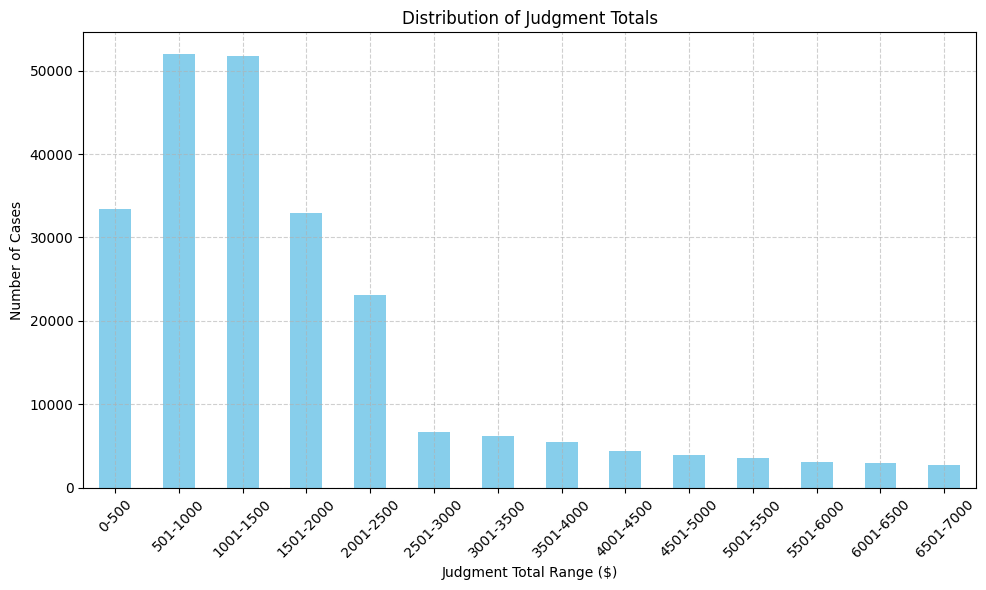

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame setup (assuming df is already loaded with 'Judgment Total')
# Define bins for the ranges of judgment totals
bins = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000]

# Create labels for these bins
labels = ['0-500', '501-1000', '1001-1500', '1501-2000', '2001-2500', '2501-3000', '3001-3500', '3501-4000', '4001-4500', '4501-5000', '5001-5500', '5501-6000', '6001-6500', '6501-7000']

# Use pd.cut to categorize the judgment totals into the defined bins
df['Range'] = pd.cut(df['Judgment Total'], bins=bins, labels=labels, right=False)

# Calculate the count of cases in each range
range_counts = df['Range'].value_counts().sort_index()

# Plotting the counts for each range
plt.figure(figsize=(10, 6))  # Set the figure size (width, height in inches)
range_counts.plot(kind='bar', color='skyblue')  # Bar plot
plt.title('Distribution of Judgment Totals')  # Title of the plot
plt.xlabel('Judgment Total Range ($)')  # X-axis label
plt.ylabel('Number of Cases')  # Y-axis label
plt.xticks(rotation=45)  # Rotate the X-axis labels for better readability
plt.grid(True, linestyle='--', alpha=0.6)  # Add a grid for easier visual estimation
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()  # Display the plot

In [ ]:
import pandas as pd
import re

# Example DataFrame setup (assuming df is loaded with your data)
# df = pd.DataFrame({'Case ID': [12345, 12346], 'Description': ["Judgment for P01 RAB PERFORMANCE RECOVERIES, LLC to recover...", "Judgment for P01 MIDLAND FUNDING, LLC to recover..."]})

def extract_plaintiff_name(description):
    # Regular expression to extract the name following "P01"
    match = re.search(r'P01\s(.*?)\sto\s', description)
    return match.group(1) if match else None

# Apply the function to the 'Description' column to create a new 'Plaintiff Name' column
df['Plaintiff Name'] = df['Description'].apply(extract_plaintiff_name)

# Print the updated DataFrame to check the results
print(df[['Case ID', 'Plaintiff Name']])

          Case ID                          Plaintiff Name
0            5481         RAB PERFORMANCE RECOVERIES, LLC
1            5487                    MIDLAND FUNDING, LLC
2            5505            CAPITAL ONE BANK (USA), N.A.
3            5515           CLEAN WAY WASTE SERVICES, INC
4            5532          CITIBANK (SOUTH DAKOTA), N. A.
...           ...                                     ...
1264416  92523127                      TRINITY EMS., INC.
1264420  92523282                      TRINITY EMS., INC.
1264426  92523553                         TRINITY EMS INC
1264427  92523574  FIRST FINANCIAL INVESTMENT FUND I, LLC
1333820  95946921                                    None

[257306 rows x 2 columns]


In [ ]:
import pandas as pd

# Assuming df is the DataFrame with 'Case ID', 'Description', and 'Judgment Total'
# Assume df is already populated and 'Judgment Total' has been calculated as previously discussed.

def extract_plaintiff_name(description):
    parts = description.split()
    if 'P01' in parts:
        # Find index of 'P01' and take the next elements up to 'to'
        start_index = parts.index('P01') + 1
        end_index = parts.index('to') if 'to' in parts else start_index
        return ' '.join(parts[start_index:end_index])
    return None

# Extract plaintiff names
df['Plaintiff Name'] = df['Description'].apply(extract_plaintiff_name)

# Filter DataFrame for judgments <= $7000
low_judgment_df = df[df['Judgment Total'] <= 7000]

# Analyze frequency of names for low judgment totals
name_frequency = low_judgment_df['Plaintiff Name'].value_counts()

# Print the most common names and their counts
print(name_frequency.head(30))  # Adjust the number to display more or fewer top names

Plaintiff Name
CAPITAL ONE BANK                       13188
CAPITAL ONE BANK (USA), N.A.           10296
MIDLAND FUNDING LLC                     4325
MIDLAND FUNDING, LLC                    3641
QUINCY MEDICAL CENTER                   3512
CAPITAL ONE BANK (USA) NA               3056
PALISADES COLLECTION LLC                2693
DISCOVER BANK                           2368
MIDLAND FUNDING, L.L.C.                 2213
NORFOLK FINANCIAL CORP.                 2179
CACH, LLC                               2159
CAPITAL ONE BANK USA NA                 2009
CAPITAL ONE BANK (USA), NA              1952
GE MONEY BANK                           1912
LVNV FUNDING LLC                        1856
CITIBANK (SOUTH DAKOTA), N.A.           1791
CAPITAL ONE BANK (USA) N.A.             1780
ARROW FINANCIAL SERVICES LLC            1716
LVNV FUNDING, LLC                       1548
PORTFOLIO RECOVERY ASSOCIATES, LLC      1328
NORFOLK FINANCIAL CORP                  1219
ARROW FINANCIAL SERVICES, LLC           

In [ ]:
import pandas as pd

# Sample data, assuming it's loaded into a DataFrame 'df' with 'Company' and 'Count' columns
data = {
    'Company': [
        'CAPITAL ONE BANK', 'CAPITAL ONE BANK (USA), N.A.', 'MIDLAND FUNDING LLC',
        'MIDLAND FUNDING, LLC', 'QUINCY MEDICAL CENTER', 'CAPITAL ONE BANK (USA) NA',
        'PALISADES COLLECTION LLC', 'DISCOVER BANK', 'MIDLAND FUNDING, L.L.C.',
        'NORFOLK FINANCIAL CORP.', 'CACH, LLC', 'CAPITAL ONE BANK USA NA',
        'CAPITAL ONE BANK (USA), NA', 'GE MONEY BANK', 'LVNV FUNDING LLC',
        'CITIBANK (SOUTH DAKOTA), N.A.', 'CAPITAL ONE BANK (USA) N.A.',
        'ARROW FINANCIAL SERVICES LLC', 'LVNV FUNDING, LLC', 'PORTFOLIO RECOVERY ASSOCIATES, LLC',
        'NORFOLK FINANCIAL CORP', 'ARROW FINANCIAL SERVICES, LLC', 'EASTERN BANK',
        'CAPITAL ONE BANK (U.S.A.), N.A.', 'NORTH STAR CAPITAL ACQUISITION LLC',
        'TRINITY EMS., INC.', 'ARBELLA MUTUAL INSURANCE COMPANY', 'HSBC BANK NEVADA, N.A.',
        'CACH LLC', 'NORTH STAR CAPITAL ACQUISITION, LLC'
    ],
    'Count': [
        13188, 10296, 4325, 3641, 3512, 3056, 2693, 2368, 2213, 2179, 2159, 2009, 1952,
        1912, 1856, 1791, 1780, 1716, 1548, 1328, 1219, 1103, 1072, 1063, 955, 879,
        830, 797, 761, 700
    ]
}

df = pd.DataFrame(data)

# Function to standardize company names
def standardize_name(name):
    # Convert to lower case and remove extra spaces
    name = name.lower().strip()
    # Remove punctuation and standardize known variations
    name = name.replace(',', '').replace('.', '').replace('-', ' ')
    name = name.replace('inc', 'incorporated').replace('llc', 'limited liability company')
    name = name.replace('n.a', 'na').replace('u.s.a.', 'usa').replace('corp.', 'corporation')
    return name

# Apply standardization
df['Standardized Company'] = df['Company'].apply(standardize_name)

# Aggregate the counts
aggregated_counts = df.groupby('Standardized Company')['Count'].sum().sort_values(ascending=False)

# Display the standardized and aggregated counts
print(aggregated_counts.head(30))  # Display top 30 entries

Standardized Company
capital one bank (usa) na                                   18147
capital one bank                                            13188
midland funding limited liability company                   10179
quincorporatedy medical center                               3512
lvnv funding limited liability company                       3404
norfolk financial corp                                       3398
cach limited liability company                               2920
arrow financial services limited liability company           2819
palisades collection limited liability company               2693
discover bank                                                2368
capital one bank usa na                                      2009
ge money bank                                                1912
citibank (south dakota) na                                   1791
north star capital acquisition limited liability company     1655
portfolio recovery associates limited liability company

In [ ]:
import pandas as pd

# Example DataFrame (your data should come similarly structured)
data = {
    'Plaintiff Name': [
        'CAPITAL ONE BANK', 'CAPITAL ONE BANK (USA), N.A.', 'MIDLAND FUNDING LLC', 'QUINCY MEDICAL CENTER',
        'MIDLAND FUNDING, LLC', 'DISCOVER BANK', 'CAPITAL ONE BANK (USA) NA', 'PALISADES COLLECTION LLC',
        'CACH, LLC', 'CITIBANK (SOUTH DAKOTA), N.A.', 'MIDLAND FUNDING, L.L.C.', 'CAPITAL ONE BANK (USA), NA',
        'CAPITAL ONE BANK USA NA', 'CAPITAL ONE BANK (USA) N.A.', 'ARROW FINANCIAL SERVICES LLC',
        'LVNV FUNDING, LLC', 'PORTFOLIO RECOVERY ASSOCIATES, LLC'
    ],
    'Cases': [
        11758, 9362, 4304, 3497, 3267, 3125, 3044, 2471, 2320, 2124, 2106, 1804, 1752, 1733, 1685, 1455, 1383
    ]
}

df = pd.DataFrame(data)

# Normalize the names
name_mapping = {
    'CAPITAL ONE BANK': 'CAPITAL ONE',
    'CAPITAL ONE BANK (USA), N.A.': 'CAPITAL ONE',
    'CAPITAL ONE BANK (USA) NA': 'CAPITAL ONE',
    'CAPITAL ONE BANK USA NA': 'CAPITAL ONE',
    'CAPITAL ONE BANK (USA), NA': 'CAPITAL ONE',
    'CAPITAL ONE BANK (USA) N.A.': 'CAPITAL ONE',
    'CAPITAL ONE  BANK (USA), N.A.': 'CAPITAL ONE',
    'CAPITAL ONE BANK (U.S.A.), N.A.': 'CAPITAL ONE',
    'MIDLAND FUNDING LLC': 'MIDLAND FUNDING',
    'MIDLAND FUNDING, LLC': 'MIDLAND FUNDING',
    'MIDLAND FUNDING, L.L.C.': 'MIDLAND FUNDING',
    'LVNV FUNDING, LLC': 'LVNV FUNDING',
    'PORTFOLIO RECOVERY ASSOCIATES, LLC': 'PORTFOLIO RECOVERY ASSOCIATES',
    'ARROW FINANCIAL SERVICES LLC': 'ARROW FINANCIAL SERVICES',
    'ARROW FINANCIAL SERVICES, LLC': 'ARROW FINANCIAL SERVICES'
}

df['Plaintiff Name'] = df['Plaintiff Name'].replace(name_mapping)

# Aggregate the cases
result = df.groupby('Plaintiff Name')['Cases'].sum().sort_values(ascending=False)

# Display the result
print(result)

Plaintiff Name
CAPITAL ONE                      29453
MIDLAND FUNDING                   9677
QUINCY MEDICAL CENTER             3497
DISCOVER BANK                     3125
PALISADES COLLECTION LLC          2471
CACH, LLC                         2320
CITIBANK (SOUTH DAKOTA), N.A.     2124
ARROW FINANCIAL SERVICES          1685
LVNV FUNDING                      1455
PORTFOLIO RECOVERY ASSOCIATES     1383
Name: Cases, dtype: int64


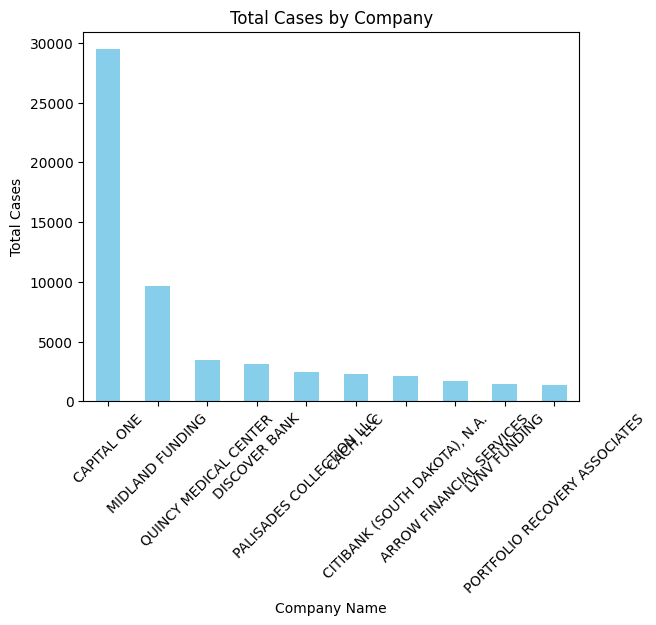

In [ ]:
import matplotlib.pyplot as plt

result.plot(kind='bar', color='skyblue')
plt.title('Total Cases by Company')
plt.xlabel('Company Name')
plt.ylabel('Total Cases')
plt.xticks(rotation=45)
plt.show()

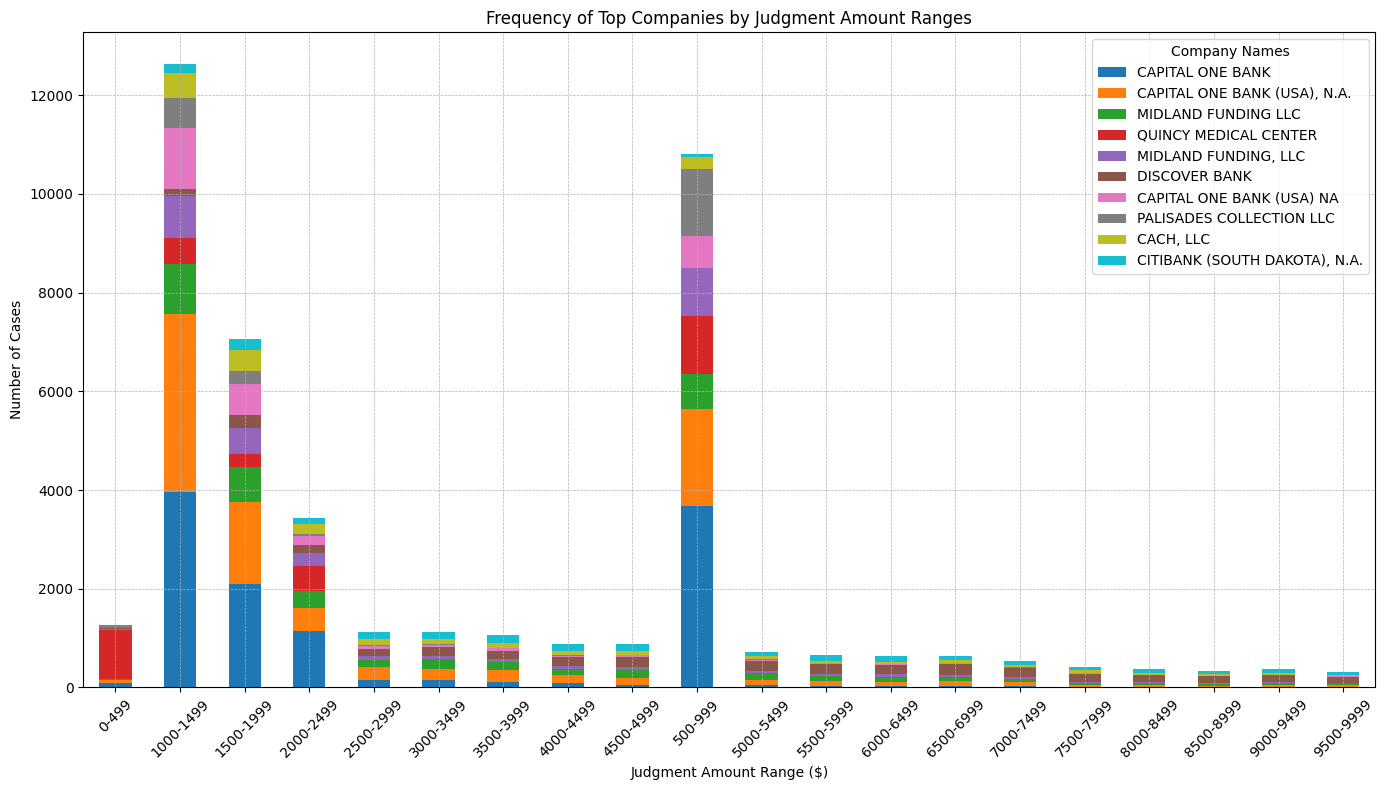

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt

def extract_company_name(description):
    """Extracts the company name following 'P01'."""
    match = re.search(r'P01\s(.*?)\sto\s', description)
    return match.group(1) if match else None

def categorize_judgment_totals(judgment_total):
    """Categorizes judgment totals into $500 increments up to a set limit."""
    bins = list(range(0, 10500, 500))  # Creating bins up to $10,000 in $500 increments
    labels = [f'{i}-{i + 499}' for i in range(0, 10000, 500)]
    return pd.cut([judgment_total], bins=bins, labels=labels, right=False)[0]

# Assuming 'df' is your DataFrame containing the necessary data
df['Company Name'] = df['Description'].apply(extract_company_name)
df['Judgment Range'] = df['Judgment Total'].apply(categorize_judgment_totals)

# Aggregate data
company_counts = df.groupby(['Company Name', 'Judgment Range']).size().unstack(fill_value=0)

# Sum across all ranges for each company and get the top 10 companies
top_companies = company_counts.sum(axis=1).nlargest(10).index

# Filter data to only include the top companies
filtered_data = company_counts.loc[top_companies]

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))
filtered_data.T.plot(kind='bar', stacked=True, ax=ax)  # Transpose to correct the orientation
ax.set_title('Frequency of Top Companies by Judgment Amount Ranges')
ax.set_xlabel('Judgment Amount Range ($)')
ax.set_ylabel('Number of Cases')
plt.xticks(rotation=45)
plt.legend(title='Company Names')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

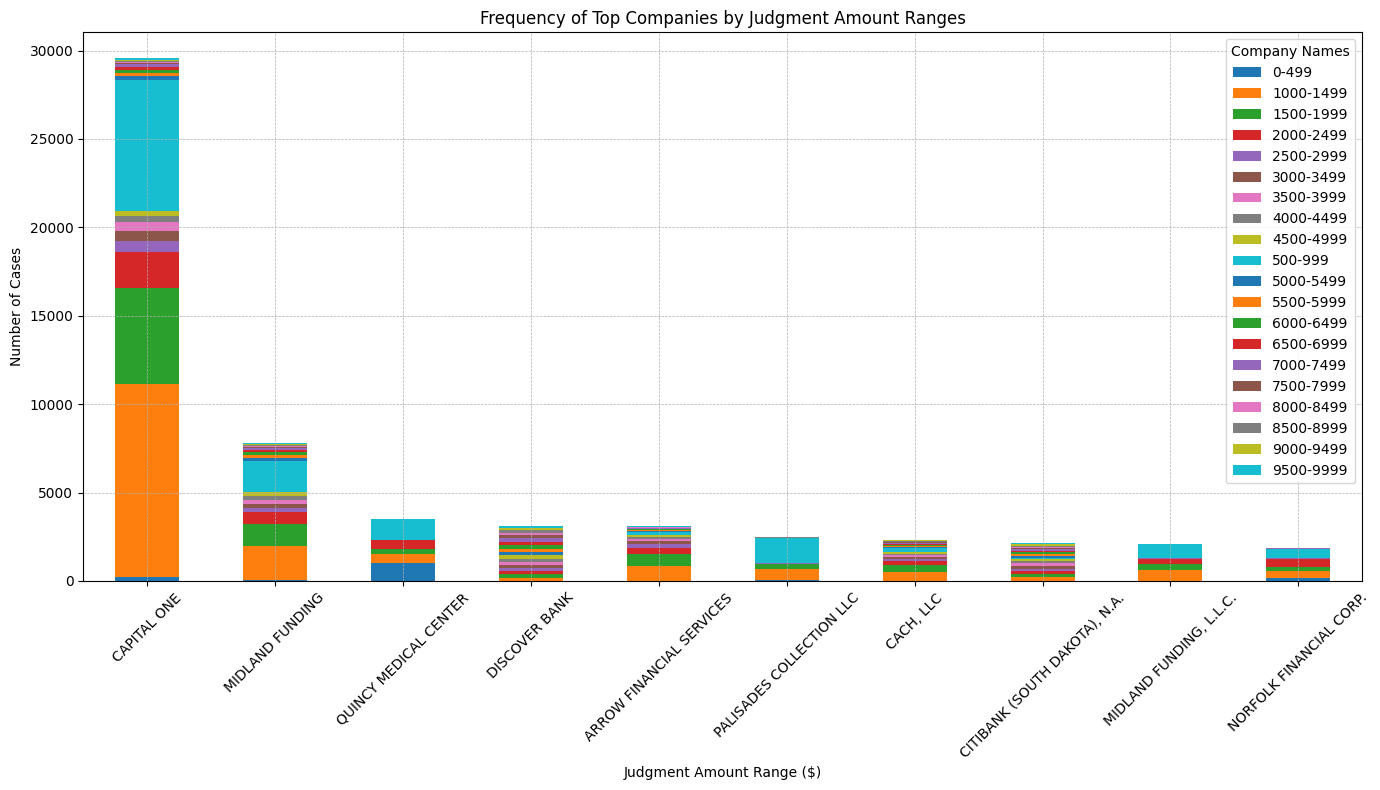

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# Assuming this is your DataFrame 'df' with a 'Company Name' and 'Judgment Total' column
# df = ... (load your DataFrame here)

# Normalization mapping based on the example you provided
name_mapping = {
    'CAPITAL ONE BANK': 'CAPITAL ONE',
    'CAPITAL ONE BANK (USA), N.A.': 'CAPITAL ONE',
    'CAPITAL ONE BANK (USA) NA': 'CAPITAL ONE',
    'CAPITAL ONE BANK USA NA': 'CAPITAL ONE',
    'CAPITAL ONE BANK (USA), NA': 'CAPITAL ONE',
    'CAPITAL ONE BANK (USA) N.A.': 'CAPITAL ONE',
    # Add other variations as needed
    'MIDLAND FUNDING LLC': 'MIDLAND FUNDING',
    'MIDLAND FUNDING, LLC': 'MIDLAND FUNDING',
    # Repeat for other companies...
    'LVNV FUNDING, LLC': 'LVNV FUNDING',
    'PORTFOLIO RECOVERY ASSOCIATES, LLC': 'PORTFOLIO RECOVERY ASSOCIATES',
    'ARROW FINANCIAL SERVICES LLC': 'ARROW FINANCIAL SERVICES',
    'ARROW FINANCIAL SERVICES, LLC': 'ARROW FINANCIAL SERVICES',
    # Continue with the rest of the mappings
}

# Normalize the company names in the DataFrame
df['Normalized Company Name'] = df['Company Name'].replace(name_mapping)

# Function to categorize judgment totals into $500 increments
def categorize_judgment_totals(judgment_total):
    bins = list(range(0, 10500, 500))  # Creating bins up to $10,000 in $500 increments
    labels = [f'{i}-{i + 499}' for i in range(0, 10000, 500)]
    return pd.cut([judgment_total], bins=bins, labels=labels, right=False)[0]

# Apply the categorization function
df['Judgment Range'] = df['Judgment Total'].apply(categorize_judgment_totals)

# Group by the normalized names and judgment range, then count occurrences
grouped_data = df.groupby(['Normalized Company Name', 'Judgment Range']).size().unstack(fill_value=0)

# Sum the occurrences across all ranges to identify the top 10 companies
top_10_companies = grouped_data.sum(axis=1).nlargest(10).index

# Filter to include only the top 10 companies
top_companies_data = grouped_data.loc[top_10_companies]

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))
top_companies_data.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Frequency of Top Companies by Judgment Amount Ranges')
ax.set_xlabel('Judgment Amount Range ($)')
ax.set_ylabel('Number of Cases')
plt.xticks(rotation=45)
plt.legend(title='Company Names')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


Frequency of Top Companies by Judgment Amount Ranges:
Judgment Range                 0-499  1000-1499  1500-1999  2000-2499  \
Normalized Company Name                                                 
CAPITAL ONE                      198      10932       5435       2058   
MIDLAND FUNDING                   49       1928       1269        631   
QUINCY MEDICAL CENTER           1001        529        267        517   
DISCOVER BANK                      8        145        257        167   
ARROW FINANCIAL SERVICES           7        811        728        342   
PALISADES COLLECTION LLC          43        609        280         37   
CACH, LLC                          5        509        414        203   
CITIBANK (SOUTH DAKOTA), N.A.      8        190        219        133   
MIDLAND FUNDING, L.L.C.           11        624        341        287   
NORFOLK FINANCIAL CORP.          166        422        213        466   

Judgment Range                 2500-2999  3000-3499  3500-3999  4000-

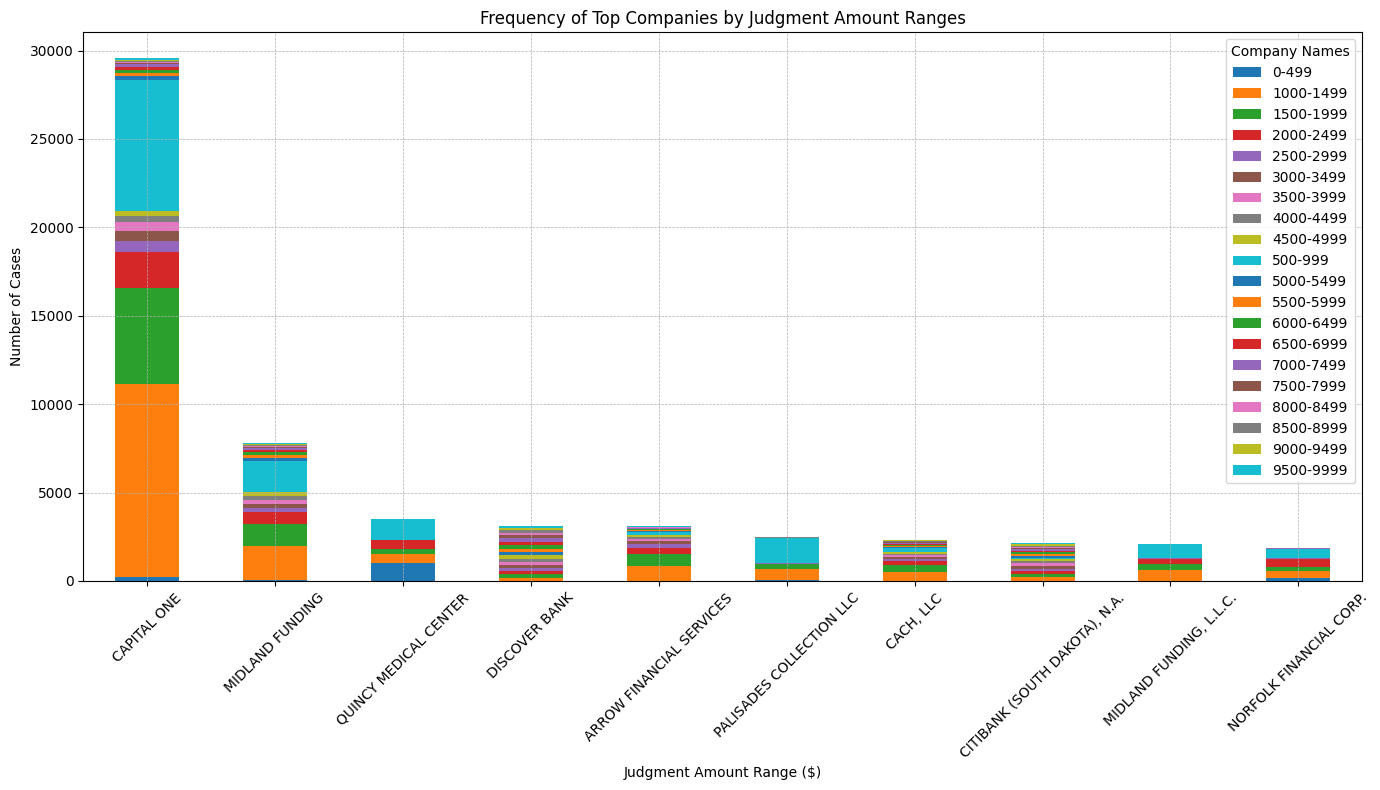

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# Assuming 'df' is the DataFrame that contains 'Company Name' and 'Judgment Total' columns

# Normalization mapping
# Normalization mapping based on the example you provided
name_mapping = {
    'CAPITAL ONE BANK': 'CAPITAL ONE',
    'CAPITAL ONE BANK (USA), N.A.': 'CAPITAL ONE',
    'CAPITAL ONE BANK (USA) NA': 'CAPITAL ONE',
    'CAPITAL ONE BANK USA NA': 'CAPITAL ONE',
    'CAPITAL ONE BANK (USA), NA': 'CAPITAL ONE',
    'CAPITAL ONE BANK (USA) N.A.': 'CAPITAL ONE',
    # Add other variations as needed
    'MIDLAND FUNDING LLC': 'MIDLAND FUNDING',
    'MIDLAND FUNDING, LLC': 'MIDLAND FUNDING',
    # Repeat for other companies...
    'LVNV FUNDING, LLC': 'LVNV FUNDING',
    'PORTFOLIO RECOVERY ASSOCIATES, LLC': 'PORTFOLIO RECOVERY ASSOCIATES',
    'ARROW FINANCIAL SERVICES LLC': 'ARROW FINANCIAL SERVICES',
    'ARROW FINANCIAL SERVICES, LLC': 'ARROW FINANCIAL SERVICES',
    # Continue with the rest of the mappings
}

# Apply the normalization mapping to the 'Company Name' column
df['Normalized Company Name'] = df['Company Name'].replace(name_mapping)

# Function to categorize judgment totals into $500 increments
def categorize_judgment_totals(judgment_total):
    bins = list(range(0, 10500, 500))  # Creating bins up to $10,000 in $500 increments
    labels = [f'{i}-{i + 499}' for i in range(0, 10000, 500)]
    return pd.cut([judgment_total], bins=bins, labels=labels, right=False)[0]

# Categorize judgment amounts
df['Judgment Range'] = df['Judgment Total'].apply(categorize_judgment_totals)

# Group by normalized names and judgment range, then count occurrences
grouped_data = df.groupby(['Normalized Company Name', 'Judgment Range']).size().unstack(fill_value=0)

# Sum occurrences across all ranges to identify the top 10 companies
top_10_companies = grouped_data.sum(axis=1).nlargest(10).index

# Filter to include only the top 10 companies
top_companies_data = grouped_data.loc[top_10_companies]

# Print out the numerical data
print("Frequency of Top Companies by Judgment Amount Ranges:")
print(top_companies_data)

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))
top_companies_data.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Frequency of Top Companies by Judgment Amount Ranges')
ax.set_xlabel('Judgment Amount Range ($)')
ax.set_ylabel('Number of Cases')
plt.xticks(rotation=45)
plt.legend(title='Company Names')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [ ]:
import pymysql
import pandas as pd

# Setting up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!',
                      host='masscourtsplus.org',
                      database='wp_courtdocs')

try:
    # Preparing a cursor and executing the query
    with cnx.cursor() as cursor:
        query = """
        SELECT case_id, action
        FROM cdocs_case_action_index
        WHERE action LIKE '%wage garnish%'
           OR description LIKE '%wage garnish%'
        """
        cursor.execute(query)
        # Fetching all matching rows
        rows = cursor.fetchall()

        # Converting to a DataFrame for easier viewing and analysis
        df = pd.DataFrame(rows, columns=['Case ID', 'Action'])

        # Displaying the DataFrame
        print(df)

finally:
    cnx.close()

        Case ID          Action
0         59876                
1         71987                
2        457381                
3        460768                
4        684386  Motion allowed
...         ...             ...
1254  105620178                
1255  105620178                
1256  105860214                
1257  106066507                
1258  106094010                

[1259 rows x 2 columns]


In [ ]:
import pymysql
import pandas as pd
import matplotlib.pyplot as plt

# Re-establishing the database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!',
                      host='masscourtsplus.org',
                      database='wp_courtdocs')
try:
    with cnx.cursor() as cursor:
        # Query to count the total number of cases
        total_query = "SELECT COUNT(*) FROM cdocs_case_action_index"
        cursor.execute(total_query)
        total_cases = cursor.fetchone()[0]
finally:
    cnx.close()

# Assuming 'df' is the DataFrame containing cases with wage garnishment
wage_garnishment_cases = len(df)

# Calculating the number of other cases
other_cases = total_cases - wage_garnishment_cases

# Data for plotting
categories = ['Wage Garnishment Cases', 'Other Cases']
values = [wage_garnishment_cases, other_cases]

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(categories, values, color=['skyblue', 'lightgreen'])
plt.xlabel('Case Type', fontsize=14)
plt.ylabel('Number of Cases', fontsize=14)
plt.title('Comparison of Wage Garnishment Cases vs. All Other Cases', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding value labels on top of each bar
for i, value in enumerate(values):
    plt.text(i, value, str(value), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
import pymysql
import pandas as pd

# Setting up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!',
                      host='masscourtsplus.org',
                      database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to find cases related to lifting wage garnishment
        query = """
        SELECT case_id, action, description
        FROM cdocs_case_action_index
        WHERE (action LIKE '%lifting wage garnish%' OR description LIKE '%lifting wage garnish%')
           OR (action LIKE '%garnishment lifted%' OR description LIKE '%garnishment lifted%')
           OR (action LIKE '%release of garnishment%' OR description LIKE '%release of garnishment%');
        """
        cursor.execute(query)
        # Fetching all matching rows
        rows = cursor.fetchall()

        # Converting results to a DataFrame
        df = pd.DataFrame(rows, columns=['Case ID', 'Action', 'Description'])

        # Display the DataFrame
        print(df)

finally:
    cnx.close()

In [ ]:
import pymysql
import pandas as pd

# Assuming you've already set up your database connection as per previous examples:
cnx = pymysql.connect(user='buspark', password='U@5p1r3!',
                      host='masscourtsplus.org',
                      database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Your SQL query
        query = """
        SELECT case_id, action, description
        FROM cdocs_case_action_index
        WHERE action LIKE '%capias%'
           OR action LIKE '%warrant%'
           OR description LIKE '%capias%'
           OR description LIKE '%warrant%';
        """
        cursor.execute(query)
        results = cursor.fetchall()

        # Convert the results into a DataFrame for easier analysis
        df = pd.DataFrame(results, columns=['Case ID', 'Action', 'Description'])

        # Display the first few rows of the DataFrame to verify
        print(df.head())
finally:
    cnx.close()

In [ ]:
import pymysql

# Setup your database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!',
                      host='masscourtsplus.org',
                      database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Modified SQL query to count matches
        query = """
        SELECT COUNT(*)
        FROM cdocs_case_action_index
        WHERE action LIKE '%capias%'
           OR action LIKE '%warrant%'
           OR description LIKE '%capias%'
           OR description LIKE '%warrant%';
        """
        cursor.execute(query)
        count = cursor.fetchone()[0]  # Fetches the count
        # Print the total count of matching cases
        print(f"Total cases involving capias warrants: {count}")
finally:
    cnx.close()



Total cases involving capias warrants: 2337075


In [ ]:
# Assuming you've already set up your database connection:
cnx = pymysql.connect(user='buspark', password='U@5p1r3!',
                      host='masscourtsplus.org',
                      database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to find cases with capias warrants removed or lifted
        query = """
        SELECT case_id, action, description
        FROM cdocs_case_action_index
        WHERE action LIKE '%capias removed%'
           OR action LIKE '%capias lifted%'
           OR description LIKE '%capias removed%'
           OR description LIKE '%capias lifted%'
           OR action LIKE '%warrant lifted%'
           OR description LIKE '%warrant lifted%'
           OR action LIKE '%warrant removal%'
           OR description LIKE '%warrant removal%';
        """
        cursor.execute(query)
        results = cursor.fetchall()

        # Convert the results into a DataFrame for easier analysis
        df = pd.DataFrame(results, columns=['Case ID', 'Action', 'Description'])

        # Display the DataFrame
        print(df)
finally:
    cnx.close()


        Case ID                   Action  \
0        534550  Debtor before the court   
1       2464663  Debtor before the court   
2       2543203                            
3       2546571                            
4       4856075  Debtor before the court   
...         ...                      ...   
4600   87185959                            
4601  100082132                            
4602  100599248                            
4603  102432996                            
4604  102432996                            

                                            Description  
0     Misc Entry: Judgment debtor before the court o...  
1     Judgment debtor before the court on capias.\n\...  
2     Notice sent to parties.\n\n\n\nPAYMENT REVIEW ...  
3     Notice sent to parties.\n\n\n\nPR 8/23/13 AT 1...  
4     Judgment debtor before the court on capias.\nb...  
...                                                 ...  
4600  Defendant Brought into Court. Warrant Recalled...  
4601  E

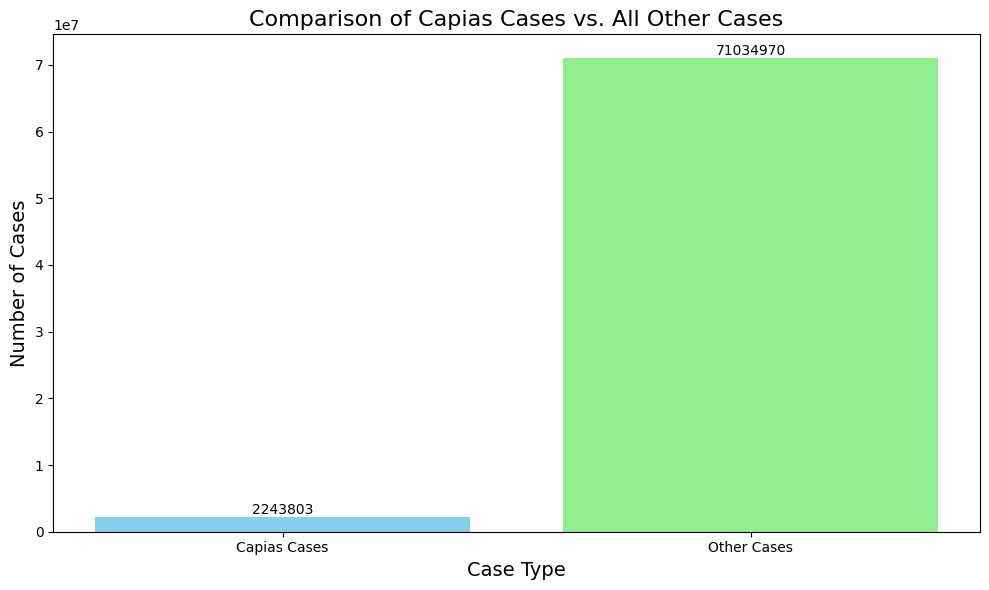

In [ ]:
import pymysql
import matplotlib.pyplot as plt

# Initialize variables to ensure they are defined
total_cases = 0
capias_cases = 0

# Database connection setup
try:
    cnx = pymysql.connect(user='buspark', password='U@5p1r3!',
                      host='masscourtsplus.org',
                      database='wp_courtdocs')


    with cnx.cursor() as cursor:
        # Fetch total number of cases
        cursor.execute("SELECT COUNT(*) FROM cdocs_case_action_index")
        total_cases = cursor.fetchone()[0]

        # Fetch number of capias cases
        cursor.execute("""
            SELECT COUNT(*)
            FROM cdocs_case_action_index
            WHERE action LIKE '%capias%' OR description LIKE '%capias%'
        """)
        capias_cases = cursor.fetchone()[0]

except pymysql.MySQLError as e:
    print(f"Error fetching data: {e}")
finally:
    cnx.close() if 'cnx' in locals() else None

# Check if the variables are correctly assigned before plotting
if total_cases > 0 and capias_cases >= 0:
    # Calculating the number of non-capias cases
    non_capias_cases = total_cases - capias_cases

    # Plotting
    categories = ['Capias Cases', 'Other Cases']
    values = [capias_cases, non_capias_cases]

    plt.figure(figsize=(10, 6))
    plt.bar(categories, values, color=['skyblue', 'lightgreen'])
    plt.xlabel('Case Type', fontsize=14)
    plt.ylabel('Number of Cases', fontsize=14)
    plt.title('Comparison of Capias Cases vs. All Other Cases', fontsize=16)

    for i, value in enumerate(values):
        plt.text(i, value, str(value), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
else:
    print("Data not available or error in data fetching.")


## **cdocs_case_meta_index**

In [ ]:
query = """
SELECT *
FROM cdocs_case_meta_index

"""
case_meta_df = pd.read_sql(query, cnx)

# Display the DataFrame

# Save the DataFrame to a CSV file
# df.to_csv("cdocs_case_meta_index.csv", index=False)
#files.download("cdocs_case_meta_index.csv")
case_meta_df

<ipython-input-13-e19be83b25e5>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  case_meta_df = pd.read_sql(query, cnx)


,post_id,case_number,case_type,case_status,file_date,status_date,judge_1_id,judge_2_id,judge_3_id,judge_4_id,judge_5_id,court_term_id,last_indexed
0,5464,1107SP000308,Supplementary Process,Disposed (Statistical Purposes),20110427,20111216,0,0,0,0,0,15,2023-05-11 08:00:15
1,5469,1107SP000307,Supplementary Process,Disposed (Statistical Purposes),20110427,20120614,0,0,0,0,0,15,2023-05-11 08:00:15
2,5475,1107SC000569,Small Claims,Disposed (Statistical Purposes),20110427,20110524,0,0,0,0,0,15,2023-05-11 08:00:15
3,5481,1107SC000568,Small Claims,Disposed (Statistical Purposes),20110426,20110630,0,0,0,0,0,15,2023-05-11 08:00:15
4,5487,1107SC000567,Small Claims,Disposed (Statistical Purposes),20110426,20110630,0,0,0,0,0,15,2023-05-11 08:00:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4925788,106430856,HD24P0451EA,Estates and Administration,Closed,20240229,20240301,0,0,0,0,0,102,2024-04-19 08:00:15
4925789,106430865,HD24P0453EA,Estates and Administration,Active,20240229,20240229,0,0,0,0,0,102,2024-04-19 08:00:15
4925790,106430880,HD24P0455EA,Estates and Administration,Closed,20240229,20240301,0,0,0,0,0,102,2024-04-19 08:00:15
4925791,106430888,HD24P0457EA,Estates and Administration,Closed,20240229,20240308,0,0,0,0,0,102,2024-04-19 08:00:15


In [ ]:
import pymysql
import pandas as pd

# Load the CSV file containing the case IDs
csv_path = '/content/capital_one_cases.csv'  # Update this to the path where your CSV file is stored
case_ids_df = pd.read_csv(csv_path)

# Convert the case IDs to a list for easier query construction
case_ids_list = case_ids_df['Case ID'].tolist()

# Prepare the SQL query to fetch relevant records
# Since case_ids_list could be large, consider batching this operation if performance issues arise
case_ids_str = ', '.join([str(id) for id in case_ids_list])  # Create a string of case IDs separated by commas

# Set up the database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        query = f"""
        SELECT COUNT(*)
        FROM cdocs_case_meta_index
        WHERE post_id IN ({case_ids_str}) AND case_type = 'Small Claims'
        """
        cursor.execute(query)
        small_claims_count = cursor.fetchone()[0]  # Fetch the count result
        print(f"Number of 'Small Claims' cases: {small_claims_count}")

finally:
    cnx.close()

Number of 'Small Claims' cases: 83553


In [ ]:
import pymysql
import pandas as pd

# Load the CSV file containing the case IDs
csv_path = '/content/citibank_cases.csv'  # Update this to the path where your CSV file is stored
case_ids_df = pd.read_csv(csv_path)

# Convert the case IDs to a list for easier query construction
case_ids_list = case_ids_df['Case ID'].tolist()

# Prepare the SQL query to fetch relevant records
# Since case_ids_list could be large, consider batching this operation if performance issues arise
case_ids_str = ', '.join([str(id) for id in case_ids_list])  # Create a string of case IDs separated by commas

# Set up the database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        query = f"""
        SELECT COUNT(*)
        FROM cdocs_case_meta_index
        WHERE post_id IN ({case_ids_str}) AND case_type = 'Small Claims'
        """
        cursor.execute(query)
        small_claims_count = cursor.fetchone()[0]  # Fetch the count result
        print(f"Number of 'Small Claims' cases: {small_claims_count}")

finally:
    cnx.close()

Number of 'Small Claims' cases: 17183


In [ ]:
import pymysql
import pandas as pd

# Load the CSV file containing the case IDs
csv_path = '/content/palisades_cases.csv'  # Update this to the path where your CSV file is stored
case_ids_df = pd.read_csv(csv_path)

# Convert the case IDs to a list for easier query construction
case_ids_list = case_ids_df['Case ID'].tolist()

# Prepare the SQL query to fetch relevant records
# Since case_ids_list could be large, consider batching this operation if performance issues arise
case_ids_str = ', '.join([str(id) for id in case_ids_list])  # Create a string of case IDs separated by commas

# Set up the database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Query to retrieve case_ids of 'Small Claims'
        query = f"""
        SELECT post_id
        FROM cdocs_case_meta_index
        WHERE post_id IN ({case_ids_str}) AND case_type = 'Small Claims'
        """
        cursor.execute(query)
        small_claims_ids = cursor.fetchall()  # Fetch the result as a list of tuples

        if small_claims_ids:
            # Convert list of tuples to DataFrame
            df_small_claims = pd.DataFrame(small_claims_ids, columns=['Case ID'])
            # Export DataFrame to CSV
            csv_output_path = '/content/palisades_small_claims.csv'  # Define the output path for the CSV file
            df_small_claims.to_csv(csv_output_path, index=False)
            print(f"CSV file has been created with the Case IDs of 'Small Claims' cases at {csv_output_path}")
        else:
            print("No 'Small Claims' cases found.")

finally:
    cnx.close()

In [ ]:
import pymysql
import pandas as pd

# Load the CSV file containing the case IDs
csv_path = '/content/citibank_cases.csv'  # Update this to the path where your CSV file is stored
case_ids_df = pd.read_csv(csv_path)

# Convert the case IDs to a list for easier query construction
case_ids_list = case_ids_df['Case ID'].tolist()

# Prepare the SQL query to fetch relevant records
# Since case_ids_list could be large, consider batching this operation if performance issues arise
case_ids_str = ', '.join([str(id) for id in case_ids_list])  # Create a string of case IDs separated by commas

# Set up the database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Query to retrieve case_ids of 'Small Claims'
        query = f"""
        SELECT post_id
        FROM cdocs_case_meta_index
        WHERE post_id IN ({case_ids_str}) AND case_type = 'Small Claims'
        """
        cursor.execute(query)
        small_claims_ids = cursor.fetchall()  # Fetch the result as a list of tuples

        if small_claims_ids:
            # Convert list of tuples to DataFrame
            df_small_claims = pd.DataFrame(small_claims_ids, columns=['Case ID'])
            # Export DataFrame to CSV
            csv_output_path = '/content/citibank_small_claims.csv'  # Define the output path for the CSV file
            df_small_claims.to_csv(csv_output_path, index=False)
            print(f"CSV file has been created with the Case IDs of 'Small Claims' cases at {csv_output_path}")
        else:
            print("No 'Small Claims' cases found.")

finally:
    cnx.close()

CSV file has been created with the Case IDs of 'Small Claims' cases at /content/citibank_small_claims.csv


In [ ]:
import pymysql
import pandas as pd

# Load the CSV file containing the case IDs
csv_path = '/content/capital_one_cases.csv'  # Update this to the path where your CSV file is stored
case_ids_df = pd.read_csv(csv_path)

# Convert the case IDs to a list for easier query construction
case_ids_list = case_ids_df['Case ID'].tolist()

# Prepare the SQL query to fetch relevant records
# Since case_ids_list could be large, consider batching this operation if performance issues arise
case_ids_str = ', '.join([str(id) for id in case_ids_list])  # Create a string of case IDs separated by commas

# Set up the database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Query to retrieve case_ids of 'Small Claims'
        query = f"""
        SELECT post_id
        FROM cdocs_case_meta_index
        WHERE post_id IN ({case_ids_str}) AND case_type = 'Small Claims'
        """
        cursor.execute(query)
        small_claims_ids = cursor.fetchall()  # Fetch the result as a list of tuples

        if small_claims_ids:
            # Convert list of tuples to DataFrame
            df_small_claims = pd.DataFrame(small_claims_ids, columns=['Case ID'])
            # Export DataFrame to CSV
            csv_output_path = '/content/capital_one_small_claims.csv'  # Define the output path for the CSV file
            df_small_claims.to_csv(csv_output_path, index=False)
            print(f"CSV file has been created with the Case IDs of 'Small Claims' cases at {csv_output_path}")
        else:
            print("No 'Small Claims' cases found.")

finally:
    cnx.close()

CSV file has been created with the Case IDs of 'Small Claims' cases at /content/capital_one_small_claims.csv


In [ ]:
import pymysql
import pandas as pd

# Load the CSV file containing the case IDs
csv_path = '/content/waterfront_capital_cases.csv'  # Update this to the path where your CSV file is stored
case_ids_df = pd.read_csv(csv_path)

# Convert the case IDs to a list for easier query construction
case_ids_list = case_ids_df['Case ID'].tolist()

# Prepare the SQL query to fetch relevant records
# Since case_ids_list could be large, consider batching this operation if performance issues arise
case_ids_str = ', '.join([str(id) for id in case_ids_list])  # Create a string of case IDs separated by commas

# Set up the database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Query to retrieve case_ids of 'Small Claims'
        query = f"""
        SELECT post_id
        FROM cdocs_case_meta_index
        WHERE post_id IN ({case_ids_str}) AND case_type = 'Small Claims'
        """
        cursor.execute(query)
        small_claims_ids = cursor.fetchall()  # Fetch the result as a list of tuples

        if small_claims_ids:
            # Convert list of tuples to DataFrame
            df_small_claims = pd.DataFrame(small_claims_ids, columns=['Case ID'])
            # Export DataFrame to CSV
            csv_output_path = '/content/waterfront_capital_small_claims.csv'  # Define the output path for the CSV file
            df_small_claims.to_csv(csv_output_path, index=False)
            print(f"CSV file has been created with the Case IDs of 'Small Claims' cases at {csv_output_path}")
        else:
            print("No 'Small Claims' cases found.")

finally:
    cnx.close()

CSV file has been created with the Case IDs of 'Small Claims' cases at /content/waterfront_capital_small_claims.csv


In [ ]:
import pymysql
import pandas as pd

# Load the CSV file containing the case IDs
csv_path = '/content/bank_of_america_cases.csv'  # Update this to the path where your CSV file is stored
case_ids_df = pd.read_csv(csv_path)

# Convert the case IDs to a list for easier query construction
case_ids_list = case_ids_df['Case ID'].tolist()

# Prepare the SQL query to fetch relevant records
# Since case_ids_list could be large, consider batching this operation if performance issues arise
case_ids_str = ', '.join([str(id) for id in case_ids_list])  # Create a string of case IDs separated by commas

# Set up the database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        query = f"""
        SELECT COUNT(*)
        FROM cdocs_case_meta_index
        WHERE post_id IN ({case_ids_str}) AND case_type = 'Small Claims'
        """
        cursor.execute(query)
        small_claims_count = cursor.fetchone()[0]  # Fetch the count result
        print(f"Number of 'Small Claims' cases: {small_claims_count}")

finally:
    cnx.close()

Number of 'Small Claims' cases: 3826


In [ ]:
import pymysql
import pandas as pd

# Load the CSV file containing the case IDs
csv_path = '/content/bank_of_america_cases.csv'  # Update this to the path where your CSV file is stored
case_ids_df = pd.read_csv(csv_path)

# Convert the case IDs to a list for easier query construction
case_ids_list = case_ids_df['Case ID'].tolist()

# Prepare the SQL query to fetch relevant records
# Since case_ids_list could be large, consider batching this operation if performance issues arise
case_ids_str = ', '.join([str(id) for id in case_ids_list])  # Create a string of case IDs separated by commas

# Set up the database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Query to retrieve case_ids of 'Small Claims'
        query = f"""
        SELECT post_id
        FROM cdocs_case_meta_index
        WHERE post_id IN ({case_ids_str}) AND case_type = 'Small Claims'
        """
        cursor.execute(query)
        small_claims_ids = cursor.fetchall()  # Fetch the result as a list of tuples

        if small_claims_ids:
            # Convert list of tuples to DataFrame
            df_small_claims = pd.DataFrame(small_claims_ids, columns=['Case ID'])
            # Export DataFrame to CSV
            csv_output_path = '/content/Boa_small_claims.csv'  # Define the output path for the CSV file
            df_small_claims.to_csv(csv_output_path, index=False)
            print(f"CSV file has been created with the Case IDs of 'Small Claims' cases at {csv_output_path}")
        else:
            print("No 'Small Claims' cases found.")

finally:
    cnx.close()

CSV file has been created with the Case IDs of 'Small Claims' cases at /content/Boa_small_claims.csv


In [ ]:
import pymysql
import pandas as pd

# Load the CSV file containing the case IDs
csv_path = '/content/cach_cases.csv'  # Update this to the path where your CSV file is stored
case_ids_df = pd.read_csv(csv_path)

# Convert the case IDs to a list for easier query construction
case_ids_list = case_ids_df['Case ID'].tolist()

# Prepare the SQL query to fetch relevant records
# Since case_ids_list could be large, consider batching this operation if performance issues arise
case_ids_str = ', '.join([str(id) for id in case_ids_list])  # Create a string of case IDs separated by commas

# Set up the database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        query = f"""
        SELECT COUNT(*)
        FROM cdocs_case_meta_index
        WHERE post_id IN ({case_ids_str}) AND case_type = 'Small Claims'
        """
        cursor.execute(query)
        small_claims_count = cursor.fetchone()[0]  # Fetch the count result
        print(f"Number of 'Small Claims' cases: {small_claims_count}")

finally:
    cnx.close()

Number of 'Small Claims' cases: 6915


In [ ]:
import pymysql
import pandas as pd

# Load the CSV file containing the case IDs
csv_path = '/content/cach_cases.csv'  # Update this to the path where your CSV file is stored
case_ids_df = pd.read_csv(csv_path)

# Convert the case IDs to a list for easier query construction
case_ids_list = case_ids_df['Case ID'].tolist()

# Prepare the SQL query to fetch relevant records
# Since case_ids_list could be large, consider batching this operation if performance issues arise
case_ids_str = ', '.join([str(id) for id in case_ids_list])  # Create a string of case IDs separated by commas

# Set up the database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Query to retrieve case_ids of 'Small Claims'
        query = f"""
        SELECT post_id
        FROM cdocs_case_meta_index
        WHERE post_id IN ({case_ids_str}) AND case_type = 'Small Claims'
        """
        cursor.execute(query)
        small_claims_ids = cursor.fetchall()  # Fetch the result as a list of tuples

        if small_claims_ids:
            # Convert list of tuples to DataFrame
            df_small_claims = pd.DataFrame(small_claims_ids, columns=['Case ID'])
            # Export DataFrame to CSV
            csv_output_path = '/content/cach_small_claims.csv'  # Define the output path for the CSV file
            df_small_claims.to_csv(csv_output_path, index=False)
            print(f"CSV file has been created with the Case IDs of 'Small Claims' cases at {csv_output_path}")
        else:
            print("No 'Small Claims' cases found.")

finally:
    cnx.close()

CSV file has been created with the Case IDs of 'Small Claims' cases at /content/cach_small_claims.csv


In [ ]:
import pymysql
import pandas as pd

# Load the CSV file containing the case IDs
csv_path = '/content/midland_credit_cases.csv'  # Update this to the path where your CSV file is stored
case_ids_df = pd.read_csv(csv_path)

# Convert the case IDs to a list for easier query construction
case_ids_list = case_ids_df['Case ID'].tolist()

# Prepare the SQL query to fetch relevant records
# Since case_ids_list could be large, consider batching this operation if performance issues arise
case_ids_str = ', '.join([str(id) for id in case_ids_list])  # Create a string of case IDs separated by commas

# Set up the database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        query = f"""
        SELECT COUNT(*)
        FROM cdocs_case_meta_index
        WHERE post_id IN ({case_ids_str}) AND case_type = 'Small Claims'
        """
        cursor.execute(query)
        small_claims_count = cursor.fetchone()[0]  # Fetch the count result
        print(f"Number of 'Small Claims' cases: {small_claims_count}")

finally:
    cnx.close()

Number of 'Small Claims' cases: 12159


In [ ]:
import pymysql
import pandas as pd

# Load the CSV file containing the case IDs
csv_path = '/content/midland_credit_cases.csv'  # Update this to the path where your CSV file is stored
case_ids_df = pd.read_csv(csv_path)

# Convert the case IDs to a list for easier query construction
case_ids_list = case_ids_df['Case ID'].tolist()

# Prepare the SQL query to fetch relevant records
# Since case_ids_list could be large, consider batching this operation if performance issues arise
case_ids_str = ', '.join([str(id) for id in case_ids_list])  # Create a string of case IDs separated by commas

# Set up the database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Query to retrieve case_ids of 'Small Claims'
        query = f"""
        SELECT post_id
        FROM cdocs_case_meta_index
        WHERE post_id IN ({case_ids_str}) AND case_type = 'Small Claims'
        """
        cursor.execute(query)
        small_claims_ids = cursor.fetchall()  # Fetch the result as a list of tuples

        if small_claims_ids:
            # Convert list of tuples to DataFrame
            df_small_claims = pd.DataFrame(small_claims_ids, columns=['Case ID'])
            # Export DataFrame to CSV
            csv_output_path = '/content/midland_credit_small_claims.csv'  # Define the output path for the CSV file
            df_small_claims.to_csv(csv_output_path, index=False)
            print(f"CSV file has been created with the Case IDs of 'Small Claims' cases at {csv_output_path}")
        else:
            print("No 'Small Claims' cases found.")

finally:
    cnx.close()

CSV file has been created with the Case IDs of 'Small Claims' cases at /content/midland_credit_small_claims.csv


In [ ]:
import pymysql
import pandas as pd

# Load the CSV file containing the case IDs
csv_path = '/content/midland_funding_cases.csv'  # Update this to the path where your CSV file is stored
case_ids_df = pd.read_csv(csv_path)

# Convert the case IDs to a list for easier query construction
case_ids_list = case_ids_df['Case ID'].tolist()

# Prepare the SQL query to fetch relevant records
# Since case_ids_list could be large, consider batching this operation if performance issues arise
case_ids_str = ', '.join([str(id) for id in case_ids_list])  # Create a string of case IDs separated by commas

# Set up the database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        query = f"""
        SELECT COUNT(*)
        FROM cdocs_case_meta_index
        WHERE post_id IN ({case_ids_str}) AND case_type = 'Small Claims'
        """
        cursor.execute(query)
        small_claims_count = cursor.fetchone()[0]  # Fetch the count result
        print(f"Number of 'Small Claims' cases: {small_claims_count}")

finally:
    cnx.close()

Number of 'Small Claims' cases: 107643


In [ ]:
import pymysql
import pandas as pd

# Load the CSV file containing the case IDs
csv_path = '/content/midland_funding_cases.csv'  # Update this to the path where your CSV file is stored
case_ids_df = pd.read_csv(csv_path)

# Convert the case IDs to a list for easier query construction
case_ids_list = case_ids_df['Case ID'].tolist()

# Prepare the SQL query to fetch relevant records
# Since case_ids_list could be large, consider batching this operation if performance issues arise
case_ids_str = ', '.join([str(id) for id in case_ids_list])  # Create a string of case IDs separated by commas

# Set up the database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Query to retrieve case_ids of 'Small Claims'
        query = f"""
        SELECT post_id
        FROM cdocs_case_meta_index
        WHERE post_id IN ({case_ids_str}) AND case_type = 'Small Claims'
        """
        cursor.execute(query)
        small_claims_ids = cursor.fetchall()  # Fetch the result as a list of tuples

        if small_claims_ids:
            # Convert list of tuples to DataFrame
            df_small_claims = pd.DataFrame(small_claims_ids, columns=['Case ID'])
            # Export DataFrame to CSV
            csv_output_path = '/content/midland_funding_small_claims.csv'  # Define the output path for the CSV file
            df_small_claims.to_csv(csv_output_path, index=False)
            print(f"CSV file has been created with the Case IDs of 'Small Claims' cases at {csv_output_path}")
        else:
            print("No 'Small Claims' cases found.")

finally:
    cnx.close()

CSV file has been created with the Case IDs of 'Small Claims' cases at /content/midland_funding_small_claims.csv


In [ ]:
import pymysql
import pandas as pd

# Load the CSV file containing the case IDs
csv_path = '/content/lvnv_cases.csv'  # Update this to the path where your CSV file is stored
case_ids_df = pd.read_csv(csv_path)

# Convert the case IDs to a list for easier query construction
case_ids_list = case_ids_df['Case ID'].tolist()

# Prepare the SQL query to fetch relevant records
# Since case_ids_list could be large, consider batching this operation if performance issues arise
case_ids_str = ', '.join([str(id) for id in case_ids_list])  # Create a string of case IDs separated by commas

# Set up the database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        query = f"""
        SELECT COUNT(*)
        FROM cdocs_case_meta_index
        WHERE post_id IN ({case_ids_str}) AND case_type = 'Small Claims'
        """
        cursor.execute(query)
        small_claims_count = cursor.fetchone()[0]  # Fetch the count result
        print(f"Number of 'Small Claims' cases: {small_claims_count}")

finally:
    cnx.close()

Number of 'Small Claims' cases: 42496


In [ ]:
import pymysql
import pandas as pd

# Load the CSV file containing the case IDs
csv_path = '/content/lvnv_cases.csv'  # Update this to the path where your CSV file is stored
case_ids_df = pd.read_csv(csv_path)

# Convert the case IDs to a list for easier query construction
case_ids_list = case_ids_df['Case ID'].tolist()

# Prepare the SQL query to fetch relevant records
# Since case_ids_list could be large, consider batching this operation if performance issues arise
case_ids_str = ', '.join([str(id) for id in case_ids_list])  # Create a string of case IDs separated by commas

# Set up the database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Query to retrieve case_ids of 'Small Claims'
        query = f"""
        SELECT post_id
        FROM cdocs_case_meta_index
        WHERE post_id IN ({case_ids_str}) AND case_type = 'Small Claims'
        """
        cursor.execute(query)
        small_claims_ids = cursor.fetchall()  # Fetch the result as a list of tuples

        if small_claims_ids:
            # Convert list of tuples to DataFrame
            df_small_claims = pd.DataFrame(small_claims_ids, columns=['Case ID'])
            # Export DataFrame to CSV
            csv_output_path = '/content/lvnv_small_claims.csv'  # Define the output path for the CSV file
            df_small_claims.to_csv(csv_output_path, index=False)
            print(f"CSV file has been created with the Case IDs of 'Small Claims' cases at {csv_output_path}")
        else:
            print("No 'Small Claims' cases found.")

finally:
    cnx.close()

CSV file has been created with the Case IDs of 'Small Claims' cases at /content/lvnv_small_claims.csv


In [ ]:
import pymysql
import pandas as pd

# Load the CSV file containing the case IDs
csv_path = '/content/portfolio_cases.csv'  # Update this to the path where your CSV file is stored
case_ids_df = pd.read_csv(csv_path)

# Convert the case IDs to a list for easier query construction
case_ids_list = case_ids_df['Case ID'].tolist()

# Prepare the SQL query to fetch relevant records
# Since case_ids_list could be large, consider batching this operation if performance issues arise
case_ids_str = ', '.join([str(id) for id in case_ids_list])  # Create a string of case IDs separated by commas

# Set up the database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        query = f"""
        SELECT COUNT(*)
        FROM cdocs_case_meta_index
        WHERE post_id IN ({case_ids_str}) AND case_type = 'Small Claims'
        """
        cursor.execute(query)
        small_claims_count = cursor.fetchone()[0]  # Fetch the count result
        print(f"Number of 'Small Claims' cases: {small_claims_count}")

finally:
    cnx.close()

Number of 'Small Claims' cases: 62644


In [ ]:
import pymysql
import pandas as pd

# Load the CSV file containing the case IDs
csv_path = '/content/portfolio_cases.csv'  # Update this to the path where your CSV file is stored
case_ids_df = pd.read_csv(csv_path)

# Convert the case IDs to a list for easier query construction
case_ids_list = case_ids_df['Case ID'].tolist()

# Prepare the SQL query to fetch relevant records
# Since case_ids_list could be large, consider batching this operation if performance issues arise
case_ids_str = ', '.join([str(id) for id in case_ids_list])  # Create a string of case IDs separated by commas

# Set up the database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Query to retrieve case_ids of 'Small Claims'
        query = f"""
        SELECT post_id
        FROM cdocs_case_meta_index
        WHERE post_id IN ({case_ids_str}) AND case_type = 'Small Claims'
        """
        cursor.execute(query)
        small_claims_ids = cursor.fetchall()  # Fetch the result as a list of tuples

        if small_claims_ids:
            # Convert list of tuples to DataFrame
            df_small_claims = pd.DataFrame(small_claims_ids, columns=['Case ID'])
            # Export DataFrame to CSV
            csv_output_path = '/content/portfolio_small_claims.csv'  # Define the output path for the CSV file
            df_small_claims.to_csv(csv_output_path, index=False)
            print(f"CSV file has been created with the Case IDs of 'Small Claims' cases at {csv_output_path}")
        else:
            print("No 'Small Claims' cases found.")

finally:
    cnx.close()

CSV file has been created with the Case IDs of 'Small Claims' cases at /content/portfolio_small_claims.csv


In [ ]:
import pymysql
import pandas as pd

# Load the CSV file containing the case IDs
csv_path = '/content/cavalry_cases.csv'  # Update this to the path where your CSV file is stored
case_ids_df = pd.read_csv(csv_path)

# Convert the case IDs to a list for easier query construction
case_ids_list = case_ids_df['Case ID'].tolist()

# Prepare the SQL query to fetch relevant records
# Since case_ids_list could be large, consider batching this operation if performance issues arise
case_ids_str = ', '.join([str(id) for id in case_ids_list])  # Create a string of case IDs separated by commas

# Set up the database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        query = f"""
        SELECT COUNT(*)
        FROM cdocs_case_meta_index
        WHERE post_id IN ({case_ids_str}) AND case_type = 'Small Claims'
        """
        cursor.execute(query)
        small_claims_count = cursor.fetchone()[0]  # Fetch the count result
        print(f"Number of 'Small Claims' cases: {small_claims_count}")

finally:
    cnx.close()

Number of 'Small Claims' cases: 13298


In [ ]:
import pymysql
import pandas as pd

# Load the CSV file containing the case IDs
csv_path = '/content/cavalry_cases.csv'  # Update this to the path where your CSV file is stored
case_ids_df = pd.read_csv(csv_path)

# Convert the case IDs to a list for easier query construction
case_ids_list = case_ids_df['Case ID'].tolist()

# Prepare the SQL query to fetch relevant records
# Since case_ids_list could be large, consider batching this operation if performance issues arise
case_ids_str = ', '.join([str(id) for id in case_ids_list])  # Create a string of case IDs separated by commas

# Set up the database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Query to retrieve case_ids of 'Small Claims'
        query = f"""
        SELECT post_id
        FROM cdocs_case_meta_index
        WHERE post_id IN ({case_ids_str}) AND case_type = 'Small Claims'
        """
        cursor.execute(query)
        small_claims_ids = cursor.fetchall()  # Fetch the result as a list of tuples

        if small_claims_ids:
            # Convert list of tuples to DataFrame
            df_small_claims = pd.DataFrame(small_claims_ids, columns=['Case ID'])
            # Export DataFrame to CSV
            csv_output_path = '/content/cavalry_small_claims.csv'  # Define the output path for the CSV file
            df_small_claims.to_csv(csv_output_path, index=False)
            print(f"CSV file has been created with the Case IDs of 'Small Claims' cases at {csv_output_path}")
        else:
            print("No 'Small Claims' cases found.")

finally:
    cnx.close()

CSV file has been created with the Case IDs of 'Small Claims' cases at /content/cavalry_small_claims.csv


In [ ]:
import pymysql
import pandas as pd

# Load the CSV file containing the case IDs
csv_path = '/content/quincy_cases.csv'  # Update this to the path where your CSV file is stored
case_ids_df = pd.read_csv(csv_path)

# Convert the case IDs to a list for easier query construction
case_ids_list = case_ids_df['Case ID'].tolist()

# Prepare the SQL query to fetch relevant records
# Since case_ids_list could be large, consider batching this operation if performance issues arise
case_ids_str = ', '.join([str(id) for id in case_ids_list])  # Create a string of case IDs separated by commas

# Set up the database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        query = f"""
        SELECT COUNT(*)
        FROM cdocs_case_meta_index
        WHERE post_id IN ({case_ids_str}) AND case_type = 'Small Claims'
        """
        cursor.execute(query)
        small_claims_count = cursor.fetchone()[0]  # Fetch the count result
        print(f"Number of 'Small Claims' cases: {small_claims_count}")

finally:
    cnx.close()

Number of 'Small Claims' cases: 4004


In [ ]:
import pymysql
import pandas as pd

# Load the CSV file containing the case IDs
csv_path = '/content/quincy_cases.csv'  # Update this to the path where your CSV file is stored
case_ids_df = pd.read_csv(csv_path)

# Convert the case IDs to a list for easier query construction
case_ids_list = case_ids_df['Case ID'].tolist()

# Prepare the SQL query to fetch relevant records
# Since case_ids_list could be large, consider batching this operation if performance issues arise
case_ids_str = ', '.join([str(id) for id in case_ids_list])  # Create a string of case IDs separated by commas

# Set up the database connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!', host='masscourtsplus.org', database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Query to retrieve case_ids of 'Small Claims'
        query = f"""
        SELECT post_id
        FROM cdocs_case_meta_index
        WHERE post_id IN ({case_ids_str}) AND case_type = 'Small Claims'
        """
        cursor.execute(query)
        small_claims_ids = cursor.fetchall()  # Fetch the result as a list of tuples

        if small_claims_ids:
            # Convert list of tuples to DataFrame
            df_small_claims = pd.DataFrame(small_claims_ids, columns=['Case ID'])
            # Export DataFrame to CSV
            csv_output_path = '/content/quincy_small_claims.csv'  # Define the output path for the CSV file
            df_small_claims.to_csv(csv_output_path, index=False)
            print(f"CSV file has been created with the Case IDs of 'Small Claims' cases at {csv_output_path}")
        else:
            print("No 'Small Claims' cases found.")

finally:
    cnx.close()

CSV file has been created with the Case IDs of 'Small Claims' cases at /content/quincy_small_claims.csv


In [ ]:
import pymysql

# Connection setup
try:
    # Using `with` statement for automatic connection handling
    with pymysql.connect(user='buspark', password='U@5p1r3!',
                         host='masscourtsplus.org', database='wp_courtdocs') as cnx:
        with cnx.cursor() as cursor:
            # SQL query to count "Small Claims", case-insensitive search
            query = """
            SELECT COUNT(*)
            FROM cdocs_case_meta_index
            WHERE case_type LIKE '%Small Claims%' COLLATE utf8mb4_general_ci;
            """
            cursor.execute(query)

            # Fetching the result
            count = cursor.fetchone()[0]  # Fetches the first row of the results which is the count

            # Displaying the number of "Small Claims" cases
            print(f"Number of 'Small Claims' cases: {count}")

except pymysql.Error as e:
    print(f"An error occurred: {e}")

Number of 'Small Claims' cases: 1807000


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

In [ ]:
duplicate_rows = df.duplicated().sum()
print("Number of duplicate rows:", duplicate_rows)

In [ ]:
data_types = df.dtypes
unique_values = df.nunique()

print("Data Types:\n", data_types)
print("Unique Values in each column:\n", unique_values)


## **cdocs_party_assignment_index**

In [ ]:
query = """
SELECT *
FROM cdocs_party_assignment_index
"""
party_assignment_df = pd.read_sql(query, cnx)

# Display the DataFrame

# Save the DataFrame to a CSV file
# df.to_csv("cdocs_party_assignment_index.csv", index=False)
# files.download("cdocs_party_assignment_index.csv")
party_assignment_df

<ipython-input-14-04069312c167>:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  party_assignment_df = pd.read_sql(query, cnx)


,party_assignment_id,party_id,party_type,attorney_id,case_id,court_term_id,last_indexed
0,5465,5461,Plaintiff,5462,5464,128,2024-04-18 16:34:23
1,5466,5463,Defendant,0,5464,128,2024-04-18 16:34:23
2,5470,5467,Plaintiff,5462,5469,15,2024-04-18 16:34:23
3,5471,5468,Defendant,0,5469,15,2024-04-18 16:34:23
4,5476,5472,Plaintiff,0,5475,15,2024-04-18 16:34:23
...,...,...,...,...,...,...,...
11629515,106424043,106424039,Plaintiff,106095099,106424042,59,2024-04-18 16:34:23
11629516,106424044,106424040,Defendant,48937307,106424042,59,2024-04-18 16:34:23
11629517,106424045,106424041,Defendant,48937307,106424042,59,2024-04-18 16:34:23
11629518,106424050,77269273,Plaintiff,102388062,106424049,59,2024-04-18 16:34:23


In [ ]:
import pymysql
import pandas as pd

# Connection setup
cnx = pymysql.connect(user='buspark', password='U@5p1r3!',
                      host='masscourtsplus.org',
                      database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to find the top 10 party_ids with party_type 'Plaintiff'
        query = """
        SELECT party_id, COUNT(*) AS count
        FROM cdocs_party_assignment_index
        WHERE party_type = 'Plaintiff'
        GROUP BY party_id
        ORDER BY count DESC
        LIMIT 40;
        """
        cursor.execute(query)

        # Fetching the results
        results = cursor.fetchall()  # Fetches all rows of the results

        # Convert fetched data to a DataFrame
        party_assignment_df = pd.DataFrame(results, columns=['party_id', 'count'])

        # Displaying the DataFrame
        print(party_assignment_df)

        # Save the DataFrame to a CSV file
        party_assignment_df.to_csv("cdocs_party_assignment_index_top10.csv", index=False)

finally:
    cnx.close()

# If you're in an environment that supports automatic downloads, such as Jupyter Notebooks, you can uncomment the following line:
# files.download("cdocs_party_assignment_index_top10.csv")


    party_id   count
0       7284  116680
1       7736  112224
2       5467  103684
3       5502   92409
4      11593   84049
5      10544   74004
6       5484   72903
7      23688   46547
8       6532   38143
9    2669040   33599
10     12815   26388
11     63738   24817
12     12742   19632
13     25906   17190
14     16546   16803
15     35115   15041
16   6865564   14572
17      7656   14418
18     16052   14360
19    115939   13617
20     12975   13089
21     50964   12631
22     13166   12356
23      7721   12334
24      6775   12317
25     27599   12117
26     22975   11533
27     18138    9777
28    140497    9677
29     69526    9390
30     10578    9062
31     33804    9032
32     15632    8951
33   3401817    8903
34     15257    8783
35     23747    8507
36     14968    7815
37   1400633    7682
38     20484    7619
39  77269273    7529


In [ ]:
import pymysql

# Setting up the connection
cnx = pymysql.connect(user='buspark', password='U@5p1r3!',
                      host='masscourtsplus.org',
                      database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # Executing the join query
        query = """
        SELECT COUNT(DISTINCT cdocs_case_meta_index.post_id) AS debt_collector_cases
        FROM cdocs_case_meta_index
        JOIN cdocs_party_assignment_index ON cdocs_case_meta_index.post_id = cdocs_party_assignment_index.case_id
        WHERE cdocs_case_meta_index.case_type IN ('small claims', 'district court')
        AND cdocs_party_assignment_index.party_type LIKE '%plaintiff%';
        """
        cursor.execute(query)
        # Fetching the count
        debt_collector_cases = cursor.fetchone()[0]

        # Display the count of debt collector cases
        print(f"Number of debt collector cases in small claims and district courts: {debt_collector_cases}")

finally:
    cnx.close()

ModuleNotFoundError: No module named 'pymysql'

In [ ]:
import matplotlib.pyplot as plt

# Assuming `debt_collector_cases` is the variable holding your count from the SQL query
# For demonstration, let's say the query returned 500 cases
debt_collector_cases = 500  # Replace with your actual count

# Data for plotting
courts = ['Small Claims & District Courts']
cases = [debt_collector_cases]

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(courts, cases, color='skyblue')
plt.xlabel('Court Type', fontsize=14)
plt.ylabel('Number of Cases', fontsize=14)
plt.title('Number of Debt Collector Cases in Small Claims & District Courts', fontsize=16)
plt.ylim(0, max(cases) + 100)  # Adjust Y-axis to make room for annotation

# Adding a text label above the bar
plt.text(courts[0], cases[0] + 50, str(cases[0]), ha='center', va='bottom', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

In [ ]:
data_types = df.dtypes
unique_values = df.nunique()

print("Data Types:\n", data_types)
print("Unique Values in each column:\n", unique_values)


## **cdocs_party_index**

In [ ]:
query = """
SELECT *
FROM cdocs_party_index

"""
party_index_df = pd.read_sql(query, cnx)

# Display the DataFrame

# Save the DataFrame to a CSV file
# df.to_csv("cdocs_party_index.csv", index=False)
#files.download("cdocs_party_index.csv")
party_index_df

<ipython-input-5-487fb4b8e9f1>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  party_index_df = pd.read_sql(query, cnx)


,post_id,party_name,party_initials,is_available_in_search,last_indexed
0,9,Adam Friedman,None,1,2016-02-18 03:04:03
1,10,Testing Inc.,None,1,2016-02-18 03:04:03
2,15,Joe Testing,None,1,2016-02-18 03:04:03
3,5461,"Potfolio Recovery Associates, Llc",None,1,2024-04-09 15:28:31
4,5463,"Irby, JR , Thomas",None,1,2024-04-09 15:28:31
...,...,...,...,...,...
4509387,106424039,Mrn Corporation D/B/A: Sippican Healthcare Center,None,1,2024-04-18 16:16:05
4509388,106424040,"Walter, Arthur",None,1,2024-04-18 16:16:05
4509389,106424041,"Walter, Marybeth",None,1,2024-04-18 16:16:05
4509390,106424048,"Obrien, Patrick T.",None,1,2024-04-18 16:16:05


In [ ]:
import pymysql
import pandas as pd

# Connection setup
cnx = pymysql.connect(user='buspark', password='U@5p1r3!',
                      host='masscourtsplus.org',
                      database='wp_courtdocs')

try:
    with cnx.cursor() as cursor:
        # SQL query to find the party_names for specific post_ids (party_ids)
        query = """
        SELECT post_id AS party_id, party_name
        FROM cdocs_party_index
        WHERE post_id IN (7284, 7736, 5467, 5502, 11593, 10544, 5484, 23688, 6532, 2669040, 12815, 63738, 12742, 25906, 16546, 35115, 6865564, 7656, 16052, 115939, 12975, 50964, 13166, 7721, 6775, 27599, 22975, 18138, 140497, 69526, 10578, 33804, 15632, 3401817, 15257, 23747, 14968, 1400633, 20484, 77269273 );
        """
        cursor.execute(query)

        # Fetching the results
        results = cursor.fetchall()  # Fetches all rows of the results

        # Convert fetched data to a DataFrame
        party_names_df = pd.DataFrame(results, columns=['party_id', 'party_name'])

        # Displaying the DataFrame
        print(party_names_df)

        # Save the DataFrame to a CSV file
        party_names_df.to_csv("cdocs_party_names_top10.csv", index=False)

finally:
    cnx.close()

# If you're in an environment that supports automatic downloads, such as Jupyter Notebooks, you can uncomment the following line:
# files.download("cdocs_party_names_top10.csv")


    party_id                                party_name
0       5467                             Discover Bank
1       5484                      Midland Funding, Llc
2       5502              Capital One Bank (Usa), N.A.
3       6532                                 Cach, Llc
4       6775           American Express Centurion Bank
5       7284        Portfolio Recovery Associates, Llc
6       7656              Arrow Financial Services Llc
7       7721                  Palisades Collection Llc
8       7736                       Midland Funding Llc
9      10544                          Capital One Bank
10     10578                             Ge Money Bank
11     11593                          LVNV Funding LLC
12     12742               Capital One Bank (USA) N.A.
13     12815                        Cavalry Spv I, Llc
14     12975                 Capital One Bank (Usa) Na
15     13166                   Fia Card Services, N.A.
16     14968                      Chase Bank Usa, N.A.
17     152

In [ ]:
import pandas as pd

# Example data
data = {
    "party_id": [7284, 7736, 5467, 5502, 11593, 10544, 5484, 23688, 6532, 2669040, 12815, 63738, 12742, 25906, 16546, 35115, 6865564, 7656, 16052, 115939, 12975, 50964, 13166, 7721, 6775, 27599, 22975, 18138, 140497, 69526, 10578, 33804, 15632, 3401817, 15257, 23747, 14968, 1400633, 20484, 77269273],
    "count": [116680, 112224, 103684, 92409, 84049, 74004, 72903, 46547, 38143, 33599, 26388, 24817, 19632, 17190, 16803, 15041, 14572, 14418, 14360, 13617, 13089, 12631, 12356, 12334, 12317, 12117, 11533, 9777, 9677, 9390, 9062, 9032, 8951, 8903, 8783, 8507, 7815, 7682, 7619, 7529],
    "party_name": ["Portfolio Recovery Associates, Llc", "Midland Funding Llc", "Discover Bank", "Capital One Bank (Usa), N.A.", "LVNV Funding LLC", "Capital One Bank", "Midland Funding, Llc", "LVNV Funding, LLC", "Cach, Llc", "Midland Credit Management, Inc", "Cavalry Spv I, Llc", "Bank of America, N.A.", "Capital One Bank (USA) N.A.", "Citibank (South Dakota), N.A.", "Citibank, N.A.", "Safety Insurance Company", "Midland Credit Management, Inc", "Arrow Financial Services Llc", "Waterfront Capital, LLC", "Commonwealth Of Massachusetts", "Capital One Bank (Usa) Na", "Capital One Bank Usa Na", "Fia Card Services, N.A.", "Palisades Collection Llc", "American Express Centurion Bank", "Wells Fargo Bank, N.A.", "Unifund Corporation", "Portfolio Recovery Associates LLC", "Deutsche Bank National Trust Company, as", "Capital One, N.A.", "Ge Money Bank", "Capital One Bank (USA), NA", "Arrow Financial Services, Llc", "Regional Homecare", "Cach LLC", "Cavalry Portfolio Services, LLC", "Chase Bank Usa, N.A.", "Midland Funding, L.L.C.", "Barclays Bank Delaware", "American Express National Bank"]
}

# Create DataFrame
df = pd.DataFrame(data)

# Normalize company names
normalize = lambda x: x.replace('Llc', '').replace('Inc', '').replace(',', '').replace('.', '').strip().upper()
df['normalized_name'] = df['party_name'].apply(normalize)

# Specific simplifications
name_replacements = {
    "CAPITAL ONE BANK (USA) NA": "CAPITAL ONE",
    "CAPITAL ONE BANK USA NA": "CAPITAL ONE",
    "CAPITAL ONE BANK": "CAPITAL ONE",
    "CAPITAL ONE BANK (USA) N.A.": "CAPITAL ONE",
    "CAPITAL ONE BANK (USA), NA": "CAPITAL ONE",
    "CAPITAL ONE, N.A.": "CAPITAL ONE",
    "MIDLAND FUNDING LLC": "MIDLAND",
    "MIDLAND FUNDING, LLC": "MIDLAND",
    "MIDLAND CREDIT MANAGEMENT, INC": "MIDLAND",
    "MIDLAND FUNDING, L.L.C.": "MIDLAND",
    "AMERICAN EXPRESS CENTURION BANK": "AMERICAN EXPRESS",
    "AMERICAN EXPRESS NATIONAL BANK": "AMERICAN EXPRESS",
    "PORTFOLIO RECOVERY ASSOCIATES LLC": "PORTFOLIO RECOVERY ASSOCIATES",
    "PORTFOLIO RECOVERY ASSOCIATES, LLC": "PORTFOLIO RECOVERY ASSOCIATES",
    "LVNV FUNDING, LLC": "LVNV FUNDING",
    "LVNV FUNDING LLC": "LVNV FUNDING",
    "CACH, LLC": "CACH",
    "CACH LLC": "CACH"
}

df['normalized_name'] = df['normalized_name'].replace(name_replacements)

# Aggregate cases
result = df.groupby('normalized_name')['count'].sum().sort_values(ascending=False).head(10)

# Display final top 10 list
print(result)

normalized_name
CAPITAL ONE                      220797
MIDLAND FUNDING                  185127
LVNV FUNDING                     130596
PORTFOLIO RECOVERY ASSOCIATES    126457
DISCOVER BANK                    103684
MIDLAND CREDIT MANAGEMENT         48171
CACH                              46926
CAVALRY SPV I                     26388
BANK OF AMERICA NA                24817
ARROW FINANCIAL SERVICES          23369
Name: count, dtype: int64


# **Disclaimer:**

MIDLAND CREDIT MANAGEMENT and MIDLAND FUNDING have been considered/merged as Midland Funding.

Similarly, AMERICAN EXPRESS CENTURION BANK and AMERICAN EXPRESS NATIONAL BANK as American Express

In [ ]:
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 case_action_id           0
case_id                  0
actor                    0
action                   0
description              0
date_time                0
file_reference_number    0
last_indexed             0
dtype: int64


In [ ]:
duplicate_rows = df.duplicated().sum()
print("Number of duplicate rows:", duplicate_rows)

Number of duplicate rows: 0


In [ ]:
data_types = df.dtypes
unique_values = df.nunique()

print("Data Types:\n", data_types)
print("Unique Values in each column:\n", unique_values)


Data Types:
 case_action_id                    int64
case_id                           int64
actor                            object
action                           object
description                      object
date_time                datetime64[ns]
file_reference_number             int64
last_indexed             datetime64[ns]
dtype: object
Unique Values in each column:
 case_action_id           100
case_id                    8
actor                      4
action                    24
description               69
date_time                 22
file_reference_number      1
last_indexed               1
dtype: int64


##cdocs_case_meta_tenant_boh_index##

In [ ]:
import pymysql
import pandas as pd

# Connection setup
cnx = pymysql.connect(user='buspark', password='U@5p1r3!',
                      host='masscourtsplus.org',
                      database='wp_courtdocs')
query = """
SELECT *
FROM cdocs_case_meta_tenant_boh_index
LIMIT 100;
"""
df = pd.read_sql(query, cnx)

# Display the DataFrame

# Save the DataFrame to a CSV file
#df.to_csv("cdocs_case_meta_tenant_boh_index.csv", index=False)
#files.download("cdocs_case_meta_tenant_boh_index.csv")
df

<ipython-input-16-2a38c2b03931>:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnx)


,post_id,case_number,case_outcome,last_indexed
0,77630981,21H84SP002563,None,2023-09-17 22:52:07
1,77631937,21H84SP000626,Dismissal,2023-09-17 22:52:07
2,78095162,18H84SP005522,Execution,2023-09-17 22:52:07
3,78095247,21H84SP001607,Judgment (No Execution),2023-09-17 22:52:07
4,78095286,18H84SP001701,Dismissal,2023-09-17 22:52:07
...,...,...,...,...
95,88428800,17H84SP004039,Agreement for Judgment,2023-09-17 22:52:07
96,88455870,20H84CV000373,None,2023-09-17 22:52:07
97,88455924,17H84CV000718,None,2023-09-17 22:52:07
98,88486623,21H84SP000547,Dismissal,2023-09-17 22:52:07


## **wp_terms**

In [ ]:
query = """
SELECT *
FROM wp_terms
"""
df = pd.read_sql(query, cnx)

# Display the DataFrame

# Save the DataFrame to a CSV file
# df.to_csv("wp_terms.csv", index=False)
# files.download("wp_terms.csv")
df

## **wp_term_taxonomy**

In [ ]:
query = """
SELECT *
FROM wp_term_taxonomy
"""
df = pd.read_sql(query, cnx)

# Display the DataFrame

# Save the DataFrame to a CSV file
# df.to_csv("wp_term_taxonomy.csv", index=False)
# files.download("wp_term_taxonomy.csv")
df

## **wp_posts**

In [ ]:
query = """
SELECT *
FROM wp_posts
limit 100
"""
df = pd.read_sql(query, cnx)

# Display the DataFrame

# Save the DataFrame to a CSV file
# df.to_csv("wp_posts.csv", index=False)
# files.download("wp_posts.csv")
df

# **Table Descriptions**

In [ ]:
query = """
DESCRIBE cdocs_case_action_index
"""

# Execute the query
cursor.execute(query)

# Fetch the results
results = cursor.fetchall()
results

(('case_action_id', 'bigint(20) unsigned', 'NO', 'PRI', None, ''),
 ('case_id', 'bigint(20) unsigned', 'NO', 'MUL', None, ''),
 ('actor', 'varchar(30)', 'NO', 'MUL', '', ''),
 ('action', 'varchar(30)', 'NO', 'MUL', None, ''),
 ('description', 'mediumtext', 'NO', 'MUL', None, ''),
 ('date_time', 'datetime', 'NO', 'MUL', None, ''),
 ('file_reference_number', 'int(2) unsigned', 'NO', 'MUL', None, ''),
 ('last_indexed', 'datetime', 'NO', 'MUL', None, ''))

In [ ]:
query = """
DESCRIBE cdocs_case_meta_index
"""

# Execute the query
cursor.execute(query)

# Fetch the results
results = cursor.fetchall()
results

(('post_id', 'bigint(20) unsigned', 'NO', 'PRI', None, 'auto_increment'),
 ('case_number', 'varchar(50)', 'NO', 'MUL', None, ''),
 ('case_type', 'varchar(100)', 'NO', 'MUL', '', ''),
 ('case_status', 'varchar(100)', 'NO', 'MUL', '', ''),
 ('file_date', 'int(8)', 'NO', 'MUL', None, ''),
 ('status_date', 'int(8)', 'NO', 'MUL', None, ''),
 ('judge_1_id', 'int(10) unsigned', 'NO', 'MUL', None, ''),
 ('judge_2_id', 'int(10) unsigned', 'NO', '', None, ''),
 ('judge_3_id', 'int(10) unsigned', 'NO', '', None, ''),
 ('judge_4_id', 'int(10) unsigned', 'NO', '', None, ''),
 ('judge_5_id', 'int(10) unsigned', 'NO', '', None, ''),
 ('court_term_id', 'int(4) unsigned', 'NO', 'MUL', None, ''),
 ('last_indexed', 'datetime', 'NO', 'MUL', None, ''))

In [ ]:
query = """
DESCRIBE cdocs_party_assignment_index
"""

# Execute the query
cursor.execute(query)

# Fetch the results
results = cursor.fetchall()
results

(('party_assignment_id', 'bigint(20) unsigned', 'NO', 'PRI', None, ''),
 ('party_id', 'bigint(20) unsigned', 'NO', 'MUL', None, ''),
 ('party_type', 'varchar(30)', 'NO', 'MUL', None, ''),
 ('attorney_id', 'bigint(20) unsigned', 'NO', 'MUL', None, ''),
 ('case_id', 'bigint(20) unsigned', 'NO', 'MUL', None, ''),
 ('court_term_id', 'bigint(20) unsigned', 'NO', 'MUL', None, ''),
 ('last_indexed', 'datetime', 'NO', 'MUL', None, ''))

In [ ]:
query = """
DESCRIBE cdocs_party_index
"""

# Execute the query
cursor.execute(query)

# Fetch the results
results = cursor.fetchall()
results

(('post_id', 'bigint(20) unsigned', 'NO', 'PRI', None, 'auto_increment'),
 ('party_name', 'varchar(255)', 'YES', 'MUL', None, ''),
 ('party_initials', 'varchar(10)', 'YES', 'MUL', None, ''),
 ('is_available_in_search', 'tinyint(1) unsigned', 'NO', 'MUL', '1', ''),
 ('last_indexed', 'datetime', 'NO', 'MUL', None, ''))

In [ ]:
query = """
DESCRIBE wp_terms
"""

# Execute the query
cursor.execute(query)

# Fetch the results
results = cursor.fetchall()
results

In [ ]:
query = """
DESCRIBE wp_term_taxonomy
"""

# Execute the query
cursor.execute(query)

# Fetch the results
results = cursor.fetchall()
results

In [ ]:
query = """
DESCRIBE wp_posts
"""

# Execute the query
cursor.execute(query)

# Fetch the results
results = cursor.fetchall()
results

# **Table Explanations**

## **cdocs_case_action_index**

This table records specific actions taken within legal cases.

**case_action_id**: A unique identifier for each action taken within a case.

**case_id**: The identifier for the case to which the action belongs.

**actor**: The entity that performed the action (e.g., Plaintiff, Court).

**action**: The type of action taken (e.g., Application filed, Appearance filed, Event scheduled).

**description**: A detailed description of the action, including relevant dates and parties involved.

**date_time**: The date (and possibly the time) when the action was taken.

**file_reference_number**: A reference number associated with the action, which could potentially be used for internal tracking or referencing specific documents.

**last_indexed**: The last date and time when the action was indexed or updated in the system.

The table provides a chronological record of actions taken within specific legal cases, detailing who did what and when. This information can be used to track the progress of a case, understand the actions of involved parties, and maintain a detailed record for legal or administrative purposes.

## **cdocs_case_meta_index**

This table contains metadata about various legal cases.

**post_id**: Serves as the unique identifier for each case entry.

**case_number**: Provides a unique number or identifier for each case.

**case_type**: Indicates the type of case, such as "Supplementary Process" or "Small Claims".

**case_status**: Shows the current status of each case, with entries like "Disposed (Statistical Purposes)".

**file_date and status_date**: Represent the filing date and the date of the last status change, respectively, formatted as integers (likely YYYYMMDD).

**judge_1_id to judge_5_id**: Contains IDs for up to five judges associated with each case, though in the sample data, these fields are populated with zeros, indicating no specific judge assignment or involvement is recorded.

**court_term_id**: Identifies the court term related to each case, with a numeric ID.

**last_indexed**: Indicates the last time the case entry was updated or indexed, with a precise timestamp.

This table is designed to track and manage case information over time, providing a structured overview of case specifics, including type, status, associated judicial officers, and key dates.

## **cdocs_party_assignment_index**

This table contains information on the assignment of parties and their attorneys to legal cases.

**party_assignment_id**: Unique identifier for each record of a party being assigned to a case.

**party_id**: Identifier for the party involved in the case.

**party_type**: The role of the party in the case (e.g., Plaintiff, Defendant).

**attorney_id**: Identifier for the attorney representing the party; a value of 0 may indicate no attorney assigned.

**case_id**: Identifier for the legal case to which the party is assigned.

**court_term_id**: Identifier for the court term during which the case is being heard.

**last_indexed**: The last time the record was updated or indexed, indicating recent changes or the addition of information.

This table facilitates tracking of who is involved in each case, their role, whether they have legal representation, and the context within which their case is being heard (e.g., specific court terms).

## **cdocs_party_index**

This table contains records of parties involved in legal cases.

**post_id**: Unique identifier for each record, auto-incremented.

**party_name**: The name of the party involved, which may not always be provided.

**party_initials**: Initials of the party, with many entries appearing to be null in this sample.

**is_available_in_search**: Indicates whether the party's information is searchable, with all shown entries being searchable (1).

**last_indexed**: The timestamp of the last update or indexing of the record.

This table catalogs parties in a way that makes them accessible for search, potentially for internal case management or public record search functionalities.

## **wp_terms**

This table stores the term data which are likely used for categorization or taxonomy purposes.

**term_id**: An auto-incremented unique identifier for each term.

**name**: The name of the term.

**slug**: A URL-friendly version of the term name, typically lowercase and with spaces replaced by hyphens.

**term_group**: A numeric value (defaulting to 0) that could be used to group terms together for specific functionalities or categorizations.

## **wp_term_taxonomy**

This table contains taxonomy information for terms.

**term_taxonomy_id**: Unique identifier for each taxonomy entry, automatically incremented.

**term_id**: References the term this taxonomy entry is associated with.
taxonomy: Indicates the type of taxonomy, such as category or court in this dataset.

**description**: A field for a textual description of the taxonomy.

**parent**: The term_id of a parent term for hierarchical relationships, with 0 indicating a top-level term.

**count**: Reflects the number of items associated with this term in the taxonomy.

## **wp_posts**

This table serves as a central hub linking various aspects of the legal case management system to WordPress's flexible content management system.

ID: Auto-incremented unique identifier for each post.

post_author: Identifier for the user who authored the post.

post_date and post_date_gmt: The local and GMT date and time of the post creation.

post_content: The main content of the post.

post_title: The title of the post.

post_excerpt: A short excerpt or summary of the post.

post_status: The current status of the post (e.g., publish, draft).

comment_status and ping_status: Statuses for comment and pingback/trackback availability.

post_password: Password for protecting the post.

post_name: A sanitized version of the post title used in URLs.

to_ping and pinged: Lists of URLs to ping or that have been pinged.

post_modified and post_modified_gmt: The last modified date and time of the post, in local and GMT.

post_content_filtered: Filtered content of the post, if any.

post_parent: The ID of the parent post, for attachments or hierarchical post types.

guid: Globally unique identifier for the post.

menu_order: Order for the post within a menu.

post_type: The type of post (e.g., post, page, custom types like attorney).

post_mime_type: MIME type if the post is an attachment.

comment_count: The number of comments on the post.

# **Exploratory Data Analysis**

## **cdocs_case_meta_index**
There are 50 types of cases, like 'Supplementary Process', 'Small Claims', etc.

There are 24 kinds of case status, like 'Disposed', 'Open', etc.

## **cdocs_party_assignment_index**
There are 63 types of parties in all cases, like 'Defendant', 'Plaintiff', etc.

There are 59230 different attornies assigned to all parties, i.e., 59230 different attornies assigned to the parties.

111 different court terms took place during which the cases were being heard.

## **cdocs_party_index**

There were 3890144 missing/null values in party_initials, so we decided to drop this column. Because party_name itself gives information about the party's name and there was no such data where we realized that party_initials was being used.

# **Note Points**
The 'cdocs_case_action_index' and 'wp_posts' table is very large (around 75 million rows) and it is not possible to display it as dataframe and do pandas data analysis on it.

In [ ]:
case_type_counts = case_meta_df['case_type'].value_counts()

# Convert frequencies to percentages
total_cases = case_type_counts.sum()
case_type_percentages = (case_type_counts / total_cases) * 100

# Select the top 50 types by frequency for plotting
top_50_case_type_percentages = case_type_percentages.nlargest(50)

# Plotting the bar chart
plt.figure(figsize=(12, 8))
top_50_case_type_percentages.plot(kind='bar', color='skyblue')
plt.title('Case Types by Percentage of Total Cases')
plt.xlabel('Case Type')
plt.ylabel('Percentage of Total Cases')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()

NameError: name 'case_meta_df' is not defined

In [ ]:
case_status_counts = case_meta_df['case_status'].value_counts()

total_cases = case_status_counts.sum()
case_status_percentages = (case_status_counts / total_cases) * 100

plt.figure(figsize=(12, 8))
case_status_percentages.plot(kind='bar', color='red')
plt.title('Case Status by Percentage of Total Cases')
plt.xlabel('Case Status')
plt.ylabel('Percentage of Total Cases (%)')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()

NameError: name 'case_meta_df' is not defined

# **Question 1 - How many cases have been filed each year over the last ten years in each court?**

In [ ]:

def parse_date(date_str):
    try:
        return pd.to_datetime(date_str, format='%Y%m%d')
    except ValueError:
        # Return None or a default date if the format is incorrect
        return None


df['file_date'] = df['file_date'].apply(parse_date)

# Drop rows where 'file_date' is None (invalid dates)
df = df.dropna(subset=['file_date'])

# Extracting the year from the 'file_date'
df['file_year'] = df['file_date'].dt.year

# Counting the number of cases filed each year, summing across all court terms
case_counts = df.groupby('file_year').size().reset_index(name='case_count')

# Filter for the last ten years
recent_years = case_counts['file_year'].max() - 10
recent_case_counts = case_counts[case_counts['file_year'] > recent_years]


print(recent_case_counts)

KeyError: 'file_date'

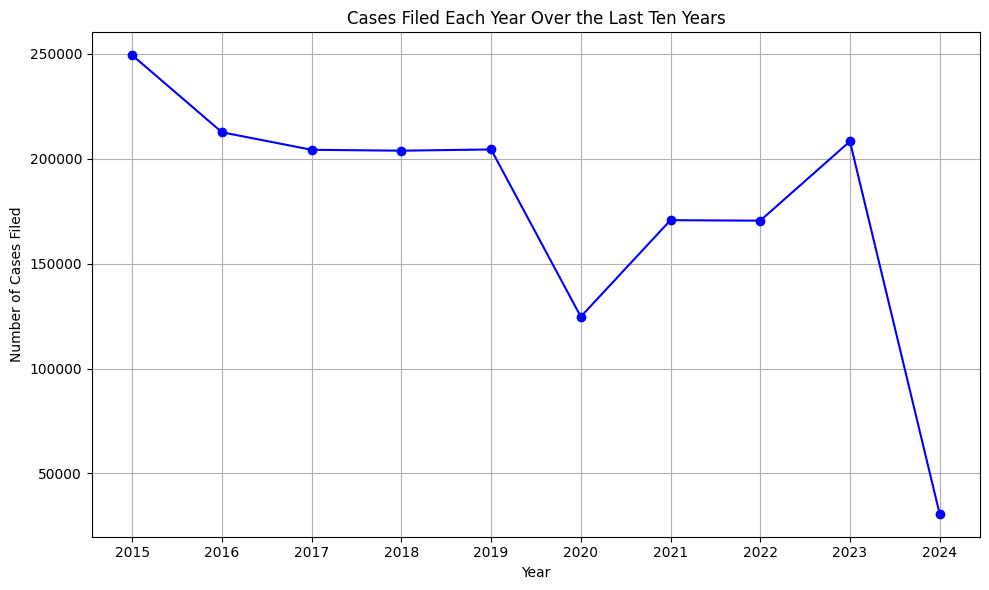

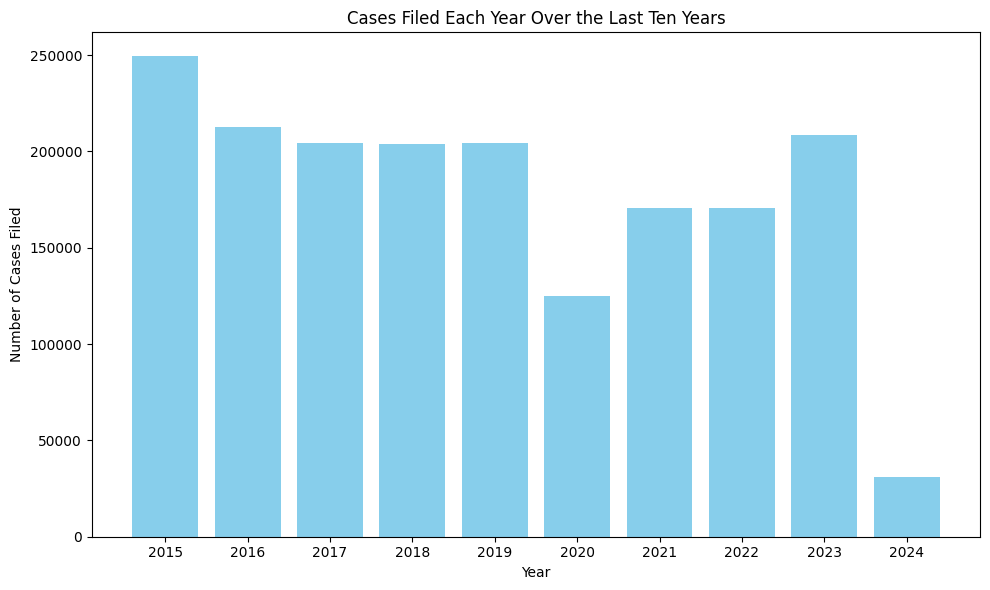

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Given data
data = {
    'file_year': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'case_count': [249336, 212631, 204275, 203849, 204445, 124730, 170731, 170498, 208288, 30787]
}
df = pd.DataFrame(data)

# Plot 1: Line plot showing trend of cases filed each year
plt.figure(figsize=(10, 6))
plt.plot(df['file_year'], df['case_count'], marker='o', linestyle='-', color='b')
plt.title('Cases Filed Each Year Over the Last Ten Years')
plt.xlabel('Year')
plt.ylabel('Number of Cases Filed')
plt.grid(True)
plt.xticks(df['file_year'])  # Ensure all years are shown
plt.tight_layout()

plt.show()

# Plot 2: Bar plot showing the number of cases filed each year
plt.figure(figsize=(10, 6))
plt.bar(df['file_year'], df['case_count'], color='skyblue')
plt.title('Cases Filed Each Year Over the Last Ten Years')
plt.xlabel('Year')
plt.ylabel('Number of Cases Filed')
plt.xticks(df['file_year'])  # Ensure all years are shown
plt.tight_layout()

plt.show()


# **Answer 1:**
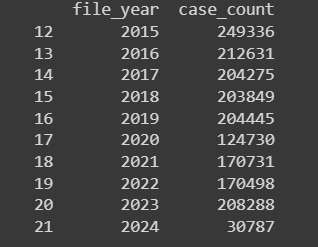

In [ ]:
unique_party_types = party_assignment_df['party_type'].unique()

print(unique_party_types)

NameError: name 'party_assignment_df' is not defined

# **Question 2 - Who are the debt collectors?**

In [ ]:

# Filter party_assignment for plaintiffs
plaintiffs = party_assignment_df[party_assignment_df['party_type'] == 'Plaintiff']

# Merge with party_index to get party names
plaintiff_names = pd.merge(plaintiffs, party_index_df, left_on='party_id', right_on='post_id', how='left')

# Select relevant columns and drop duplicates to see unique plaintiff names
unique_plaintiffs = plaintiff_names[['party_name']].drop_duplicates()
plaintiff_names_array = unique_plaintiffs['party_name'].tolist()
plaintiff_names_str = "\n".join(plaintiff_names_array)
file_path = '/unique_plaintiff_names.txt'
with open(file_path, 'w') as file:
    file.write(plaintiff_names_str)

print(len(plaintiff_names_array))

NameError: name 'party_assignment_df' is not defined

# **Answer 2**
There are total 1139771 debt collectors, assuming "Plaintiff" represents debt collectors. The link to the file containing names of all the debt collectors:
https://drive.google.com/file/d/1s6575UrxAaryvXIxTa5Zrw-MfgPiMbgr/view?usp=drive_link